In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
basedir = './국토교통부_실거래가_토지/'
filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&(f.startswith('토지'))]
filenames

['토지(매매)__실거래가_20210111203755.csv',
 '토지(매매)__실거래가_20210111203839.csv',
 '토지(매매)__실거래가_20210111203931.csv',
 '토지(매매)__실거래가_20210111204029.csv',
 '토지(매매)__실거래가_20210111204114.csv',
 '토지(매매)__실거래가_20210111204202.csv',
 '토지(매매)__실거래가_20210111204250.csv',
 '토지(매매)__실거래가_20210111204328.csv',
 '토지(매매)__실거래가_20210111204423.csv',
 '토지(매매)__실거래가_20210111204513.csv',
 '토지(매매)__실거래가_20210111204605.csv',
 '토지(매매)__실거래가_20210111204654.csv',
 '토지(매매)__실거래가_20210111204802.csv',
 '토지(매매)__실거래가_20210111204844.csv',
 '토지(매매)__실거래가_20210111204925.csv']

In [3]:
land_specs_df = pd.read_csv('./토지특성정보/AL_11_D195_20200925.csv', encoding='euc-kr')
print(land_specs_df.shape)
land_specs_df.head()

c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(7468497, 26)


,고유번호,법정동코드,법정동명,대장구분코드,대장구분명,지번,토지일련번호,기준년도,기준월,지목코드,지목명,토지면적,용도지역코드1,용도지역명1,용도지역코드2,용도지역명2,토지이용상황코드,토지이동상황,지형높이코드,지형높이,지형형상코드,지형형상,도로접면코드,도로접면,공시지가,데이터기준일자
0,1111010100100010000,1111010100,서울특별시 종로구 청운동,1.0,일반,1,1,2013,1,8,대,15622.1,13,제1종일반주거지역,0,지정되지않음,120,연립,2,평지,4,사다리형,6,소로한면,2840000,2017-10-17
1,1111010100100010000,1111010100,서울특별시 종로구 청운동,1.0,일반,1,1,2014,1,8,대,15622.1,13,제1종일반주거지역,0,지정되지않음,140,아파트,2,평지,4,사다리형,6,소로한면,2933000,2017-10-17
2,1111010100100010000,1111010100,서울특별시 종로구 청운동,1.0,일반,1,1,2015,1,8,대,15622.1,13,제1종일반주거지역,0,지정되지않음,140,아파트,2,평지,4,사다리형,6,소로한면,3053000,2017-10-17
3,1111010100100010000,1111010100,서울특별시 종로구 청운동,1.0,일반,1,1,2016,1,8,대,15622.1,13,제1종일반주거지역,0,지정되지않음,140,아파트,2,평지,4,사다리형,6,소로한면,3234000,2017-10-17
4,1111010100100010000,1111010100,서울특별시 종로구 청운동,1.0,일반,1,1,2017,1,8,대,15622.1,13,제1종일반주거지역,0,지정되지않음,140,아파트,2,평지,4,사다리형,6,소로한면,3488000,2018-05-23


In [4]:
dfs_list = []
for file in filenames:
    df = pd.read_csv(basedir + file, encoding='euc-kr', header=14)
    dfs_list.append(df)
concat_df = pd.concat(dfs_list).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(110710, 10)


,시군구,번지,지목,용도지역,도로조건,계약년월,계약일,계약면적(㎡),거래금액(만원),지분구분
0,서울특별시 구로구 오류동,2*,대,제2종일반주거지역,8m미만,200601,1,23.14,"1,890",
1,서울특별시 관악구 신림동,산9*,임야,제3종일반주거지역,25m미만,200601,2,26.00,"1,432",지분
2,서울특별시 강남구 역삼동,7**,대,제3종일반주거지역,8m미만,200601,2,393.30,"267,750",
3,서울특별시 서초구 신원동,3**,전,개발제한구역,8m미만,200601,2,684.00,"53,820",
4,서울특별시 관악구 신림동,산1**,임야,제3종일반주거지역,25m미만,200601,3,24.00,"1,325",지분


In [5]:
def mask_landnum(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        splitted = x.split('-')
        x = splitted[0]
        
        try:
            int(x)
            x = str(int(x))
        except:
            str_locs_list = []
            for i in range(len(x)):
                try:
                    int(x[i])
                except:
                    str_locs_list.append(i)
                    pass
            
            int_loc = str_locs_list[-1] + 1
            
            '''int_loc = None
            for i in range(len(x)):
                try:
                    int(x[i])
                    int_loc = i
                    break
                except:
                    pass'''

            x = str(int(x[int_loc:]))

        
        if len(x) == 1:
            return '*'
        else:
            firstnum = x[0]
            mask = ''
            for i in range(len(x)-1):
                mask += '*'

            return firstnum + mask

In [6]:
land_specs_df['번지_masked'] = land_specs_df['대장구분명'].apply(lambda x: '산' if x == '산' else '') + land_specs_df['지번'].apply(mask_landnum)

In [7]:
def correct_price(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        return int(x.replace(',',''))

In [8]:
concat_df['계약년도'] = concat_df['계약년월'].apply(lambda x: int(str(x)[:4]))
concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(correct_price)
concat_df['면적당가격'] = concat_df['거래금액(만원)'] / concat_df['계약면적(㎡)']

In [9]:
def show_inter_df(row, df):
    # row is a land_trade_df row
    # df is the land_specs_df
    
    row = row.copy()
    df = df.copy()
    
    first_df = df[df['법정동명'].str.contains(row['시군구'].split(' ')[-1])]
    second_df = first_df[first_df['지목명'] == row['지목']]
    third_df = second_df[second_df['번지_masked'] == row['번지']]
    fourth_df = third_df[third_df['토지면적'] == row['계약면적(㎡)']]
    fifth_df = fourth_df[fourth_df['용도지역명1'] == row['용도지역']]
    sixth_df = fifth_df[fifth_df['기준년도'] == row['계약년도']]
    
    if sixth_df.shape[0] == 0:
        print('sixth failed')
        if fifth_df.shape[0] == 0:
            print('fifth failed')
            if fourth_df.shape[0] == 0:
                print('fourth failed')
                if third_df.shape[0] == 0:
                    print('third failed')
                    if second_df.shape[0] == 0:
                        print('second failed')
                        if first_df.shape[0] == 0:
                            print('first_failed')
                            raise ValueError('myerror')
                        else:
                            return first_df
                    else:
                        return second_df
                else:
                    return third_df
            else:
                return fourth_df
        else:
            return fifth_df
    else:
        return sixth_df

In [10]:
# 세로한면(가), 세로한면(불), 세로각지(가), 세로각지(불)

In [11]:
# - 도로조건 메모: 세로한면, 지정되지않음, 맹지

In [12]:
def roadcondition2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if x == '-':
            return '기타'
        elif x == '8m미만':
            return '기타'
        else:
            return x

In [13]:
#concat_df['도로조건2'] = concat_df['도로조건'].apply(roadcondition2)

In [15]:
def roadcondition_landspecs(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if '광대' in x:
            return '25m이상'
        elif '중로' in x:
            return '25m미만'
        elif '소로' in x:
            return '12m미만'
        elif ('세로한' in x) | ('세로각' in x):
            return '8m미만'
        else:
            return '-'

In [16]:
land_specs_df['도로조건'] = land_specs_df['도로접면'].apply(roadcondition_landspecs)
land_specs_df['도로조건'].value_counts()

8m미만     3997196
-        1264186
12m미만     978500
25m이상     664475
25m미만     563230
Name: 도로조건, dtype: int64

In [22]:
cols_to_drop = ['고유번호', '법정동코드', '대장구분코드', '토지일련번호', '지번', '기준월', '지목코드', '용도지역코드1',
                '용도지역코드2', '토지이용상황코드', '지형높이코드', '지형형상코드', '도로접면코드', '데이터기준일자'
               ]

In [23]:
land_specs_df.drop(columns=cols_to_drop, inplace=True)

In [26]:
no_share_df = concat_df[concat_df['지분구분'] == ' '].drop(columns=['지분구분']).reset_index(drop=True)

In [28]:
land_specs_df.drop(columns=['대장구분명'], inplace=True)

In [29]:
land_specs_df.rename(columns={'법정동명':'시군구', '지목명':'지목', '토지면적':'계약면적(㎡)', '기준년도':'계약년도',
                              '용도지역명1':'용도지역', '번지_masked':'번지'}, inplace=True)

In [33]:
land_specs_df.drop(columns=['도로접면'], inplace=True)

In [247]:
merge_df = no_share_df.merge(land_specs_df, on=['시군구', '번지', '지목', '용도지역', '도로조건', '계약면적(㎡)', '계약년도'])
merge_df.shape

(59176, 16)

In [248]:
merge_df['시'] = merge_df['시군구'].apply(lambda x: x.split(' ')[1])
merge_df['동'] = merge_df['시군구'].apply(lambda x: x.split(' ')[2])

In [249]:
merge_df.drop(columns=['시군구'], inplace=True)

In [250]:
merge_df['동번지'] = merge_df['동'] + merge_df['번지']
merge_df['동번지'].nunique()

2585

In [40]:
merge_df.drop(columns=['번지', '동번지'], inplace=True)

In [251]:
merge_df['계약월'] = merge_df['계약년월'].apply(lambda x: int(str(x)[-2:]))

In [252]:
def accumulated_days(x):
    # x is a month in number
    
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    accum = 0
    for i in range(0,x-1):
        accum += month_days[i]
        
    return accum

In [253]:
def time_linear(df):
    df = df.copy()
    
    df['time_linear'] = (df['계약년도'] - 2006) + (df['계약월'].apply(accumulated_days) + (df['계약일'] - 1))/365    
    
    return df

In [254]:
merge_df = time_linear(merge_df)
merge_df.head()

,번지,지목,용도지역,도로조건,계약년월,계약일,계약면적(㎡),거래금액(만원),계약년도,면적당가격,용도지역명2,토지이동상황,지형높이,지형형상,공시지가,시,동,동번지,계약월,time_linear
0,1**,종교용지,제2종일반주거지역,12m미만,201301,1,45.0,14027,2013,311.711111,지정되지않음,주상기타,평지,사다리형,2640000,노원구,상계동,상계동1**,1,7.00000
1,1**,종교용지,제2종일반주거지역,12m미만,201301,1,9.0,2805,2013,311.666667,지정되지않음,주상기타,평지,사다리형,2640000,노원구,상계동,상계동1**,1,7.00000
2,5**,대,제2종일반주거지역,8m미만,201301,2,66.0,13266,2013,201.000000,지정되지않음,다세대,평지,사다리형,1560000,강북구,수유동,수유동5**,1,7.00274
3,5**,대,제2종일반주거지역,8m미만,201301,2,66.0,13266,2013,201.000000,지정되지않음,단독,평지,사다리형,1340000,강북구,수유동,수유동5**,1,7.00274
4,5**,대,제2종일반주거지역,8m미만,201301,2,66.0,13266,2013,201.000000,지정되지않음,단독,평지,부정형,1300000,강북구,수유동,수유동5**,1,7.00274


In [255]:
merge_df['공시지가'] = merge_df['공시지가'] / 10000
merge_df.rename(columns={'공시지가':'공시지가(만원)'}, inplace=True)

In [256]:
def month_cos(x):
    # x is a month in number
    
    return np.cos(((x-1)/12)*2*np.pi)

def month_sin(x):
    # x is a month in number
    
    return np.sin(((x-1)/12)*2*np.pi)

In [257]:
merge_df['month_cos'] = merge_df['계약월'].apply(month_cos)
merge_df['month_sin'] = merge_df['계약월'].apply(month_sin)

In [277]:
drop1_df = merge_df.drop(columns=['계약년월', '계약일', '계약년도', '계약월', '시', '동', '번지'])
drop1_df.head()

,지목,용도지역,도로조건,계약면적(㎡),거래금액(만원),면적당가격,용도지역명2,토지이동상황,지형높이,지형형상,공시지가(만원),동번지,time_linear,month_cos,month_sin
0,종교용지,제2종일반주거지역,12m미만,45.0,14027,311.711111,지정되지않음,주상기타,평지,사다리형,264.0,상계동1**,7.00000,1.0,0.0
1,종교용지,제2종일반주거지역,12m미만,9.0,2805,311.666667,지정되지않음,주상기타,평지,사다리형,264.0,상계동1**,7.00000,1.0,0.0
2,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,다세대,평지,사다리형,156.0,수유동5**,7.00274,1.0,0.0
3,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,단독,평지,사다리형,134.0,수유동5**,7.00274,1.0,0.0
4,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,단독,평지,부정형,130.0,수유동5**,7.00274,1.0,0.0


In [278]:
cat_cols = ['지목', '용도지역', '도로조건', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '동번지']

In [279]:
from sklearn.preprocessing import OneHotEncoder

In [280]:
enc = OneHotEncoder()

In [281]:
drop1_df.dropna(inplace=True)

In [282]:
prac = enc.fit_transform(drop1_df[cat_cols])

In [283]:
onehot_col_names = enc.get_feature_names(cat_cols).tolist()
len(onehot_col_names)

2688

In [284]:
prac_df = drop1_df.copy()

In [285]:
prac.shape

(59175, 2688)

In [286]:
prac_array = prac.toarray()

In [287]:
for i in tqdm(range(len(onehot_col_names))):
    prac_df[onehot_col_names[i]] = prac_array[:,i]

100%|█████████████████████████████████████████████████████████████████████████████| 2688/2688 [00:08<00:00, 321.04it/s]


In [288]:
prac_df.drop(columns=cat_cols, inplace=True)

In [289]:
prac_df.shape

(59175, 2695)

In [290]:
prac2_df = prac_df.drop(columns=['계약면적(㎡)', '거래금액(만원)'])
prac2_df.shape

(59175, 2693)

In [291]:
prac2_df.head()

,면적당가격,공시지가(만원),time_linear,month_cos,month_sin,지목_공원,지목_공장용지,지목_과수원,지목_구거,지목_답,지목_대,지목_도로,지목_묘지,지목_사적지,지목_수도용지,지목_유원지,지목_유지,지목_임야,지목_잡종지,지목_전,지목_제방,지목_종교용지,지목_주유소용지,지목_주차장,지목_창고용지,지목_철도용지,지목_체육용지,지목_하천,지목_학교용지,용도지역_개발제한구역,용도지역_근린상업지역,용도지역_생산녹지지역,용도지역_유통상업지역,용도지역_일반상업지역,용도지역_자연녹지지역,용도지역_제1종일반주거지역,용도지역_제1종전용주거지역,용도지역_제2종일반주거지역,용도지역_제3종일반주거지역,용도지역_준공업지역,용도지역_준주거지역,용도지역_중심상업지역,도로조건_-,도로조건_12m미만,도로조건_25m미만,도로조건_25m이상,도로조건_8m미만,용도지역명2_개발제한구역,용도지역명2_근린상업지역,용도지역명2_생산녹지지역,용도지역명2_일반상업지역,용도지역명2_자연녹지지역,용도지역명2_제1종일반주거지역,용도지역명2_제1종전용주거지역,용도지역명2_제2종일반주거지역,용도지역명2_제3종일반주거지역,용도지역명2_준공업지역,용도지역명2_준주거지역,용도지역명2_지정되지않음,토지이동상황_공업기타,토지이동상황_공업나지,토지이동상황_공업용,토지이동상황_공원등,토지이동상황_과수원,토지이동상황_기타,토지이동상황_다세대,토지이동상황_단독,토지이동상황_답,토지이동상황_답기타,토지이동상황_도로등,토지이동상황_상업기타,토지이동상황_상업나지,토지이동상황_상업용,토지이동상황_아파트,토지이동상황_업무용,토지이동상황_여객자동차터미널,토지이동상황_연립,토지이동상황_위험시설,토지이동상황_유해.혐오시설,토지이동상황_임야기타,토지이동상황_자연림,토지이동상황_전,토지이동상황_전기타,토지이동상황_조림,토지이동상황_주거기타,토지이동상황_주거나지,토지이동상황_주상기타,토지이동상황_주상나지,토지이동상황_주상용,토지이동상황_주차장등,토지이동상황_콘도미니엄,토지이동상황_토지임야,토지이동상황_하천등,지형높이_고지,지형높이_급경사,지형높이_완경사,지형높이_저지,지형높이_지정되지않음,지형높이_평지,지형형상_가로장방,지형형상_부정형,지형형상_사다리형,지형형상_삼각형,지형형상_세로장방,지형형상_역삼각형,지형형상_자루형,지형형상_정방형,지형형상_지정되지않음,동번지_가락동1**,동번지_가락동2*,동번지_가락동4**,동번지_가락동7*,동번지_가락동9**,동번지_가리봉동*,동번지_가리봉동1*,동번지_가리봉동1**,동번지_가리봉동2*,동번지_가리봉동5**,동번지_가리봉동7**,동번지_가리봉동8*,동번지_가리봉동9*,동번지_가산동*,동번지_가산동1**,동번지_가산동2**,동번지_가산동3*,동번지_가산동3**,동번지_가산동4*,동번지_가산동5**,동번지_가산동6**,동번지_가산동7**,동번지_가양동1**,동번지_가양동2**,동번지_가양동3*,동번지_가양동4*,동번지_가양동4**,동번지_가양동5*,동번지_가양동6*,동번지_가양동8*,동번지_가양동9*,동번지_가양동산*,동번지_가회동1*,동번지_가회동1**,동번지_가회동2*,동번지_가회동3*,동번지_가회동6*,동번지_가회동7*,동번지_갈월동*,동번지_갈월동1*,동번지_갈월동5*,동번지_갈월동6*,동번지_갈월동7*,동번지_갈월동8*,동번지_갈월동9*,동번지_갈현동*,동번지_갈현동1*,동번지_갈현동1**,동번지_갈현동2*,동번지_갈현동2**,동번지_갈현동3**,동번지_갈현동4**,동번지_갈현동5**,동번지_갈현동산*,동번지_강일동1*,동번지_강일동1**,동번지_강일동3*,동번지_강일동4**,동번지_강일동6**,동번지_강일동7**,동번지_강일동8*,동번지_개봉동1**,동번지_개봉동2*,동번지_개봉동2**,동번지_개봉동3*,동번지_개봉동3**,동번지_개봉동4**,동번지_개봉동6*,동번지_개봉동7*,동번지_개봉동산*,동번지_개봉동산2*,동번지_개봉동산5*,동번지_개포동1*,동번지_개포동1**,동번지_개포동1***,동번지_개포동6**,동번지_개포동산2**,동번지_개화동2**,동번지_개화동3**,동번지_개화동4**,동번지_개화동5**,동번지_개화동6**,동번지_개화동산*,동번지_개화동산2*,동번지_개화동산3*,동번지_개화동산4*,동번지_개화동산6*,동번지_개화동산7*,동번지_개화동산9*,동번지_거여동1**,동번지_거여동2**,동번지_거여동3*,동번지_거여동3**,동번지_거여동5**,동번지_거여동산5*,동번지_견지동7*,동번지_경운동9*,동번지_계동*,동번지_계동1**,동번지_고덕동2**,동번지_고덕동3*,동번지_고덕동3**,동번지_고덕동4**,동번지_고덕동5**,동번지_고덕동6*,동번지_고덕동6**,동번지_고덕동7*,동번지_고덕동8*,동번지_고척동1**,동번지_고척동2**,동번지_고척동3**,동번지_고척동4*,동번지_고척동5*,동번지_고척동7*,동번지_고척동9*,동번지_고척동산1*,동번지_공덕동*,동번지_공덕동1*,동번지_공덕동1**,동번지_공덕동2*,동번지_공덕동2**,동번지_공덕동3**,동번지_공덕동4*,동번지_공덕동5*,동번지_공덕동7*,동번지_공덕동8*,동번지_공덕동9*,동번지_공릉동1**,동번지_공릉동2*,동번지_공릉동2**,동번지_공릉동3**,동번지_공릉동4**,동번지_공릉동5**,동번지_공릉동6**,동번지_공릉동산2**,동번지_공릉동산5*,동번지_공평동1*,동번지_공평동1**,동번지_공평동3*,동번지_공평동4*,동번지_공평동5*,동번지_공평동6*,...,동번지_풍납동1**,동번지_풍납동2**,동번지_풍납동3**,동번지_풍납동4**,동번지_풍납동8*,동번지_필동1가1*,동번지_필동1가2*,동번지_필동1가3*,동번지_필동1가4*,동번지_필동2가1*,동번지_필동2가1**,동번지_필동2가2*,동번지_필동2가7*,동번지_필동2가8*,동번지_필동2가9*,동번지_필동3가2*,동번지_필동3가3*,동번지_필동3가4*,동번지_필동3가7*,동번지_필운동1**,동번지_필운동2**,동번지_필운동7*,동번지_하계동*,동번지_하계동1**,동번지_하계동2**,동번지_하계동6*,동번지_하계동7*,동번지_하왕십리동1***,동번지_하왕십리동2**,동번지_하왕십리동3**,동번지_하왕십리동5**,동번지_하왕십리동6**,동번지_하왕십리동7**,동번지_하왕십리동8**,동번지_하왕십리동9**,동번지_하왕십리동산*,동번지_하왕십리동산1*,동번지_하월곡동1*,동번지_하월곡동1**,동번지_하월곡동2*,동번지_하월곡동3*,동번지_하월곡동4*,동번지_하월곡동5*,동번지_하월곡동6*,동번지_하월곡동7*,동번지_하월곡동8*,동번지_하월곡동9*,동번지_하중동2*,동번지_한강로1가1*,동번지_한강로1가1**,동번지_한강로1가2**,동번지_한강로2가*,동번지_한강로2가1*,동번지_한강로2가1**,동번지_한강로2가2**,동번지_한강로2가3*,동번지_한강로2가3**,동번지_한강로2가4**,동번지_한강로2가6*,동번지_한강로2가8*,동번지_한강로3가4*,동번지_한강로3가6*,동번지_한남동*,동번지_한남동1*,동번지_한남동1**,동번지_한남동2**,동번지_한남동3*,동번지_한남동3**,동번지_한남동4**,동번지_한남동5**,동번지_한남동6*,동번지_한남동6**,동번지_한남동7**,동번지_한남동8*,동번지_한남동9*,동번지_합정동1**,동번지_합정동2**,동번지_합정동3**,동번지_합정동4**,동번지_합정동8*,동번지_항동*,동번지_항동1*,동번지_항동6*,동번지_항동7*,동번지_항동산2*,동번지_행당동1**,동번지_행당동2*,동번지_행당동2**,동번지_행당동3*,동번지_행당동3**,동번지_행당동9*,동번지_행촌동*,동번지_행촌동1*,동번지_행촌동1**,동번지_행촌동2*,동번지_행촌동2**,동번지_행촌동3*,동번지_행촌동4*,동번지_현석동1**,동번지_현저동*,동번지_혜화동*,동번지_혜화동1*,동번지_혜화동2*,동번지_혜화동3*,동번지_혜화동7*,동번지_홍은동*,동번지_홍은동1*,동번지_홍은동1**,동번지_홍은동2*,동번지_홍은동2**,동번지_홍은동3**,동번지_홍은동4*,동번지_홍은동4**,동번지_홍은동산*,동번지_홍은동산1*,동번지_홍은동산2*,동번지_홍익동1**,동번지_홍익동2**,동번지_홍익동3**,동번지_홍익동5**,동번지_홍제동*,동번지_홍제동1**,동번지_홍제동2*,동번지_홍제동2**,동번지_홍제동3*,

# Outlier identification

In [292]:
from sklearn.ensemble import IsolationForest

In [293]:
model = IsolationForest(n_estimators=100, n_jobs=6, verbose=1)

In [294]:
%%time
model.fit(prac2_df)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   28.5s remaining:   57.0s


Wall time: 29.4 s


[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   29.0s finished


IsolationForest(n_jobs=6, verbose=1)

In [295]:
%%time
preds = model.predict(prac2_df)

Wall time: 47.4 s


In [296]:
preds_srs = pd.Series(preds)

In [297]:
preds_srs.describe()

count    59175.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [298]:
preds_srs.value_counts()

1    59175
dtype: int64

In [147]:
# Every row is an inlier

In [146]:
prac_df.drop(columns=['outlier'], inplace=True)

In [161]:
training_data_df = prac_df.copy()

In [162]:
training_data_df.head()

,계약면적(㎡),거래금액(만원),면적당가격,공시지가(만원),time_linear,month_cos,month_sin,지목_공원,지목_공장용지,지목_과수원,지목_구거,지목_답,지목_대,지목_도로,지목_묘지,지목_사적지,지목_수도용지,지목_유원지,지목_유지,지목_임야,지목_잡종지,지목_전,지목_제방,지목_종교용지,지목_주유소용지,지목_주차장,지목_창고용지,지목_철도용지,지목_체육용지,지목_하천,지목_학교용지,용도지역_개발제한구역,용도지역_근린상업지역,용도지역_생산녹지지역,용도지역_유통상업지역,용도지역_일반상업지역,용도지역_자연녹지지역,용도지역_제1종일반주거지역,용도지역_제1종전용주거지역,용도지역_제2종일반주거지역,용도지역_제3종일반주거지역,용도지역_준공업지역,용도지역_준주거지역,용도지역_중심상업지역,도로조건_-,도로조건_12m미만,도로조건_25m미만,도로조건_25m이상,도로조건_8m미만,용도지역명2_개발제한구역,용도지역명2_근린상업지역,용도지역명2_생산녹지지역,용도지역명2_일반상업지역,용도지역명2_자연녹지지역,용도지역명2_제1종일반주거지역,용도지역명2_제1종전용주거지역,용도지역명2_제2종일반주거지역,용도지역명2_제3종일반주거지역,용도지역명2_준공업지역,용도지역명2_준주거지역,용도지역명2_지정되지않음,토지이동상황_공업기타,토지이동상황_공업나지,토지이동상황_공업용,토지이동상황_공원등,토지이동상황_과수원,토지이동상황_기타,토지이동상황_다세대,토지이동상황_단독,토지이동상황_답,토지이동상황_답기타,토지이동상황_도로등,토지이동상황_상업기타,토지이동상황_상업나지,토지이동상황_상업용,토지이동상황_아파트,토지이동상황_업무용,토지이동상황_여객자동차터미널,토지이동상황_연립,토지이동상황_위험시설,토지이동상황_유해.혐오시설,토지이동상황_임야기타,토지이동상황_자연림,토지이동상황_전,토지이동상황_전기타,토지이동상황_조림,토지이동상황_주거기타,토지이동상황_주거나지,토지이동상황_주상기타,토지이동상황_주상나지,토지이동상황_주상용,토지이동상황_주차장등,토지이동상황_콘도미니엄,토지이동상황_토지임야,토지이동상황_하천등,토지이동상황_nan,지형높이_고지,지형높이_급경사,지형높이_완경사,지형높이_저지,지형높이_지정되지않음,지형높이_평지,지형형상_가로장방,지형형상_부정형,지형형상_사다리형,지형형상_삼각형,지형형상_세로장방,지형형상_역삼각형,지형형상_자루형,지형형상_정방형,지형형상_지정되지않음,시_강남구,시_강동구,시_강북구,시_강서구,시_관악구,시_광진구,시_구로구,시_금천구,시_노원구,시_도봉구,시_동대문구,시_동작구,시_마포구,시_서대문구,시_서초구,시_성동구,시_성북구,시_송파구,시_양천구,시_영등포구,시_용산구,시_은평구,시_종로구,시_중구,시_중랑구,동_가락동,동_가리봉동,동_가산동,동_가양동,동_가회동,동_갈월동,동_갈현동,동_강일동,동_개봉동,동_개포동,동_개화동,동_거여동,동_견지동,동_경운동,동_계동,동_고덕동,동_고척동,동_공덕동,동_공릉동,동_공평동,동_공항동,동_과해동,동_관수동,동_관철동,동_관훈동,동_광장동,동_광희동1가,동_광희동2가,동_교남동,동_교북동,동_구기동,동_구로동,동_구산동,동_구수동,동_구의동,동_군자동,동_궁동,동_궁정동,동_권농동,동_금호동1가,동_금호동2가,동_금호동3가,동_금호동4가,동_길동,동_길음동,동_낙원동,동_남가좌동,동_남대문로4가,동_남대문로5가,동_남산동1가,동_남산동2가,동_남산동3가,동_남영동,동_남창동,동_남학동,동_남현동,동_내곡동,동_내발산동,동_내자동,동_냉천동,동_노고산동,동_노량진동,동_녹번동,동_논현동,동_누상동,동_누하동,동_능동,동_다동,동_답십리동,동_당산동,동_당산동1가,동_당산동2가,동_당산동3가,동_당산동4가,동_당산동5가,동_당산동6가,동_당인동,동_당주동,동_대림동,동_대방동,동_대신동,동_대조동,동_대치동,동_대현동,동_대흥동,동_도곡동,동_도림동,동_도봉동,동_도선동,동_도원동,동_도화동,동_독산동,동_돈암동,동_돈의동,동_동교동,동_동빙고동,동_동선동1가,동_동선동2가,동_동선동3가,동_동선동4가,동_동선동5가,동_동소문동2가,동_동소문동3가,동_동소문동5가,동_동소문동6가,동_동소문동7가,동_동숭동,동_동자동,동_동작동,동_둔촌동,동_등촌동,동_마곡동,동_마장동,동_마천동,...,동_상암동,동_상왕십리동,동_상월곡동,동_상일동,동_서계동,동_서교동,동_서린동,동_서빙고동,동_서소문동,동_서초동,동_석관동,동_석촌동,동_성내동,동_성북동,동_성북동1가,동_성산동,동_성수동1가,동_성수동2가,동_세곡동,동_소격동,동_소공동,동_송월동,동_송정동,동_송파동,동_수색동,동_수서동,동_수송동,동_수유동,동_수표동,동_수하동,동_순화동,동_숭인동,동_시흥동,동_신계동,동_신공덕동,동_신교동,동_신길동,동_신내동,동_신당동,동_신대방동,동_신도림동,동_신림동,동_신문로1가,동_신문로2가,동_신사동,동_신설동,동_신수동,동_신영동,동_신원동,동_신월동,동_신정동,동_신창동,동_신천동,동_신촌동,동_쌍림동,동_쌍문동,동_아현동,동_안국동,동_안암동1가,동_안암동2가,동_안암동3가,동_안암동5가,동_암사동,동_양재동,동_양평동1가,동_양평동2가,동_양평동3가,동_양평동4가,동_양평동5가,동_양평동6가,동_여의도동,동_역삼동,동_역촌동,동_연건동,동_연남동,동_연지동,동_연희동,동_염곡동,동_염리동,동_염창동,동_영등포동,동_영등포동1가,동_영등포동2가,동_영등포동3가,동_영등포동4가,동_영등포동5가,동_영등포동6가,동_영등포동7가,동_영등포동8가,동_영천동,동_예관동,동_예장동,동_예지동,동_오곡동,동_오금동,동_오류동,동_오쇠동,동_오장동,동_옥수동,동_옥인동,동_옥천동,동_온수동,동_와룡동,동_외발산동,동_용강동,동_용답동,동_용두동,동_용문동,동_용산동2가,동_용산동3가,동_우면동,동_우이동,동_운니동,동_원남동,동_원서동,동_원지동,동_원효로1가,동_원효로2가,동_원효로3가,동_원효로4가,동_월계동,동_율현동,동_을지로1가,동_을지로2가,동_을지로3가,동_을지로4가,동_을지로5가,동_을지로6가,동_을지로7가,동_응봉동,동_응암동,동_이문동,동_이촌동,동_이태원동,동_이화동,동_익선동,동_인사동,동_인의동,동_인현동1가,동_인현동2가,동_일원동,동_입정동,동_자곡동,동_자양동,동_잠실동,동_잠원동,동_장교동,동_장사동,동_장안동,동_장위동,동_장지동,동_장충동1가,동_장충동2가,동_재동,동_저동1가,동_저동2가,동_전농동,동_정동,동_정릉동,동_제기동,동_종로2가,동_종로3가,동_종로4가,동_종로5가,동_종로6가,동_종암동,동_주교동,동_주성동,동_주자동,동_중계동,동_중곡동,동_중동,동_중림동,동_중학동,동_중화동,동_증산동,동_진관동,동_창동,동_창성동,동_창신동,동_창전동,동_창천동,동_천연동,동_천왕동,동_천호동,동_청담동,동_청량리동,동_청암동,동_청운동,동_청진동,동_청파동1가,동_청파동2가,동_청파동3가,동_체부동,동_초동,동_충무로1가,동_충무로2가,동_충무로3가,동_충무로4가,동_충무로5가,동_충신동,동_충정로2가,동_충정로3가,동_태평로2가,동_토정동,동_통의동,동_통인동,동_팔판동,동_평동,동_평창동,동_풍납동,동_필동1가,동_필동2가,동_필동3가,동_필운동,동_하계동,동_하왕십리동,동_하월곡동,동_하중동,동_한강로1가,동_한강로2가,동_한강로3가,동_한남동,동_합정동,동_항동,동_행당동,동_행촌동,동_현석동,동_현저동,동_혜화동,동_홍은동,동_홍익동,동_홍제동,동_홍지동,동_홍파동,동_화곡동,동_화동,동_화양동,동_황학동,동_회기동,동_회현동1가,동_회현동2가,동_회현동3가,동_효자동,동_효제동,동_효창동,동_후암동,동_휘경동,동_흑석동,동_흥인동
0,45.0,14027,311.711111,264.0,7.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [163]:
training_data_df.drop(columns=['계약면적(㎡)'], inplace=True)

# ML models

## Lgb

In [313]:
prac_df = drop1_df.copy()
prac_df.head()

,지목,용도지역,도로조건,계약면적(㎡),거래금액(만원),면적당가격,용도지역명2,토지이동상황,지형높이,지형형상,공시지가(만원),동번지,time_linear,month_cos,month_sin
0,종교용지,제2종일반주거지역,12m미만,45.0,14027,311.711111,지정되지않음,주상기타,평지,사다리형,264.0,상계동1**,7.00000,1.0,0.0
1,종교용지,제2종일반주거지역,12m미만,9.0,2805,311.666667,지정되지않음,주상기타,평지,사다리형,264.0,상계동1**,7.00000,1.0,0.0
2,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,다세대,평지,사다리형,156.0,수유동5**,7.00274,1.0,0.0
3,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,단독,평지,사다리형,134.0,수유동5**,7.00274,1.0,0.0
4,대,제2종일반주거지역,8m미만,66.0,13266,201.000000,지정되지않음,단독,평지,부정형,130.0,수유동5**,7.00274,1.0,0.0


In [314]:
cat_cols

['지목', '용도지역', '도로조건', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '동번지']

In [315]:
for col in cat_cols:
    colmap_df = pd.DataFrame({'cat':prac_df[col].unique(), 'map':[i for i in range(len(prac_df[col].unique()))]})
    colmap = {}
    for i in range(colmap_df.shape[0]):
        colmap[colmap_df['cat'][i]] = colmap_df['map'][i]
    prac_df[col] = prac_df[col].map(colmap)

In [316]:
prac_df.head()

,지목,용도지역,도로조건,계약면적(㎡),거래금액(만원),면적당가격,용도지역명2,토지이동상황,지형높이,지형형상,공시지가(만원),동번지,time_linear,month_cos,month_sin
0,0,0,0,45.0,14027,311.711111,0,0,0,0,264.0,0,7.00000,1.0,0.0
1,0,0,0,9.0,2805,311.666667,0,0,0,0,264.0,0,7.00000,1.0,0.0
2,1,0,1,66.0,13266,201.000000,0,1,0,0,156.0,1,7.00274,1.0,0.0
3,1,0,1,66.0,13266,201.000000,0,2,0,0,134.0,1,7.00274,1.0,0.0
4,1,0,1,66.0,13266,201.000000,0,2,0,1,130.0,1,7.00274,1.0,0.0


In [317]:
prac_df.drop(columns=['계약면적(㎡)', '거래금액(만원)'], inplace=True)

In [333]:
prac_df.head()

,지목,용도지역,도로조건,면적당가격,용도지역명2,토지이동상황,지형높이,지형형상,공시지가(만원),동번지,time_linear,month_cos,month_sin
0,0,0,0,311.711111,0,0,0,0,264.0,0,7.00000,1.0,0.0
1,0,0,0,311.666667,0,0,0,0,264.0,0,7.00000,1.0,0.0
2,1,0,1,201.000000,0,1,0,0,156.0,1,7.00274,1.0,0.0
3,1,0,1,201.000000,0,2,0,0,134.0,1,7.00274,1.0,0.0
4,1,0,1,201.000000,0,2,0,1,130.0,1,7.00274,1.0,0.0


In [334]:
idx_to_drop = []
for col in cat_cols:
    for dong in tqdm(prac_df[col].unique()):
        dong_df = prac_df[prac_df[col] == dong]
        q1 = dong_df['면적당가격'].quantile(0.25)
        q3 = dong_df['면적당가격'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = 1.5 * iqr

        to_drop_df = dong_df[(dong_df['면적당가격'] < q1 - outlier_step)|(dong_df['면적당가격'] > q3 + outlier_step)]
        [idx_to_drop.append(idx) for idx in to_drop_df.index]

100%|█████████████████████████████████████████████████████████████████████████████| 2585/2585 [00:04<00:00, 545.01it/s]


In [335]:
len(set(idx_to_drop))

9812

In [336]:
no_outliers_df = prac_df.drop(idx_to_drop)
print(no_outliers_df.shape)

(49363, 13)


In [322]:
prac_df.shape

(59175, 13)

In [323]:
no_outliers_df = prac_df.drop(threshhold_df.index)
print(no_outliers_df.shape)

(55394, 13)


In [324]:
training_data_df = no_outliers_df.copy()

In [325]:
test_data_df = training_data_df.sample(frac=0.2)
train_data_df = training_data_df.drop(test_data_df.index)
val_data_df = train_data_df.sample(frac=0.2)
train_data_df = train_data_df.drop(val_data_df.index)

In [326]:
target_cols = ['면적당가격']
target_col = '면적당가격'
x_test = test_data_df.drop(columns=target_cols)
y_test = test_data_df[target_col]
x_train = train_data_df.drop(columns=target_cols)
y_train = train_data_df[target_col]
x_val = val_data_df.drop(columns=target_cols)
y_val = val_data_df[target_col]
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(11079, 12)
(35452, 12)
(8863, 12)


In [327]:
y_train.describe()

count    35452.000000
mean       490.621445
std        540.803168
min          0.016949
25%        242.000000
50%        355.226642
75%        562.920635
max      17715.112360
Name: 면적당가격, dtype: float64

<AxesSubplot:>

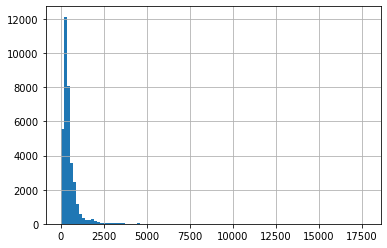

In [328]:
y_train.hist(bins=100)

In [329]:
import lightgbm as lgb

In [337]:
params = {
    'objective':'huber',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse'
}

In [338]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)

In [339]:
# without 토지면적 log
num_rounds = 50000000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 35452, number of used features: 12
[LightGBM] [Info] Start training from score 490.621444
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 532.64
[100]	valid_0's rmse: 532.468
[150]	valid_0's rmse: 532.297
[200]	valid_0's rmse: 532.126
[250]	valid_0's rmse: 531.955
[300]	valid_0's rmse: 531.785
[350]	valid_0's rmse: 531.614
[400]	valid_0's rmse: 531.443
[450]	valid_0's rmse: 531.272
[500]	valid_0's rmse: 531.102
[550]	valid_0's rmse: 530.932
[600]	valid_0's rmse: 530.762
[650]	valid_0's rmse: 530.593
[700]	valid_0's rmse: 530.424
[750]	valid_0's rmse: 530.255
[800]	valid_0's rmse: 530.087
[850]	valid_0's rmse: 529.919
[900]	valid_0's rms

[12550]	valid_0's rmse: 495.386
[12600]	valid_0's rmse: 495.258
[12650]	valid_0's rmse: 495.131
[12700]	valid_0's rmse: 495.004
[12750]	valid_0's rmse: 494.876
[12800]	valid_0's rmse: 494.748
[12850]	valid_0's rmse: 494.621
[12900]	valid_0's rmse: 494.494
[12950]	valid_0's rmse: 494.368
[13000]	valid_0's rmse: 494.242
[13050]	valid_0's rmse: 494.117
[13100]	valid_0's rmse: 493.992
[13150]	valid_0's rmse: 493.868
[13200]	valid_0's rmse: 493.745
[13250]	valid_0's rmse: 493.623
[13300]	valid_0's rmse: 493.501
[13350]	valid_0's rmse: 493.379
[13400]	valid_0's rmse: 493.257
[13450]	valid_0's rmse: 493.136
[13500]	valid_0's rmse: 493.014
[13550]	valid_0's rmse: 492.893
[13600]	valid_0's rmse: 492.771
[13650]	valid_0's rmse: 492.649
[13700]	valid_0's rmse: 492.527
[13750]	valid_0's rmse: 492.405
[13800]	valid_0's rmse: 492.285
[13850]	valid_0's rmse: 492.164
[13900]	valid_0's rmse: 492.043
[13950]	valid_0's rmse: 491.922
[14000]	valid_0's rmse: 491.802
[14050]	valid_0's rmse: 491.682
[14100]	

[25550]	valid_0's rmse: 468.252
[25600]	valid_0's rmse: 468.166
[25650]	valid_0's rmse: 468.08
[25700]	valid_0's rmse: 467.995
[25750]	valid_0's rmse: 467.91
[25800]	valid_0's rmse: 467.825
[25850]	valid_0's rmse: 467.739
[25900]	valid_0's rmse: 467.655
[25950]	valid_0's rmse: 467.57
[26000]	valid_0's rmse: 467.485
[26050]	valid_0's rmse: 467.401
[26100]	valid_0's rmse: 467.317
[26150]	valid_0's rmse: 467.233
[26200]	valid_0's rmse: 467.149
[26250]	valid_0's rmse: 467.065
[26300]	valid_0's rmse: 466.981
[26350]	valid_0's rmse: 466.896
[26400]	valid_0's rmse: 466.812
[26450]	valid_0's rmse: 466.727
[26500]	valid_0's rmse: 466.643
[26550]	valid_0's rmse: 466.558
[26600]	valid_0's rmse: 466.474
[26650]	valid_0's rmse: 466.39
[26700]	valid_0's rmse: 466.305
[26750]	valid_0's rmse: 466.222
[26800]	valid_0's rmse: 466.138
[26850]	valid_0's rmse: 466.054
[26900]	valid_0's rmse: 465.97
[26950]	valid_0's rmse: 465.886
[27000]	valid_0's rmse: 465.802
[27050]	valid_0's rmse: 465.718
[27100]	valid

[38450]	valid_0's rmse: 448.999
[38500]	valid_0's rmse: 448.932
[38550]	valid_0's rmse: 448.868
[38600]	valid_0's rmse: 448.805
[38650]	valid_0's rmse: 448.738
[38700]	valid_0's rmse: 448.673
[38750]	valid_0's rmse: 448.609
[38800]	valid_0's rmse: 448.547
[38850]	valid_0's rmse: 448.483
[38900]	valid_0's rmse: 448.417
[38950]	valid_0's rmse: 448.352
[39000]	valid_0's rmse: 448.289
[39050]	valid_0's rmse: 448.228
[39100]	valid_0's rmse: 448.166
[39150]	valid_0's rmse: 448.103
[39200]	valid_0's rmse: 448.04
[39250]	valid_0's rmse: 447.977
[39300]	valid_0's rmse: 447.912
[39350]	valid_0's rmse: 447.848
[39400]	valid_0's rmse: 447.784
[39450]	valid_0's rmse: 447.721
[39500]	valid_0's rmse: 447.659
[39550]	valid_0's rmse: 447.597
[39600]	valid_0's rmse: 447.535
[39650]	valid_0's rmse: 447.474
[39700]	valid_0's rmse: 447.412
[39750]	valid_0's rmse: 447.351
[39800]	valid_0's rmse: 447.29
[39850]	valid_0's rmse: 447.23
[39900]	valid_0's rmse: 447.17
[39950]	valid_0's rmse: 447.111
[40000]	vali

[51350]	valid_0's rmse: 434.171
[51400]	valid_0's rmse: 434.119
[51450]	valid_0's rmse: 434.068
[51500]	valid_0's rmse: 434.015
[51550]	valid_0's rmse: 433.963
[51600]	valid_0's rmse: 433.911
[51650]	valid_0's rmse: 433.859
[51700]	valid_0's rmse: 433.807
[51750]	valid_0's rmse: 433.756
[51800]	valid_0's rmse: 433.703
[51850]	valid_0's rmse: 433.651
[51900]	valid_0's rmse: 433.6
[51950]	valid_0's rmse: 433.549
[52000]	valid_0's rmse: 433.497
[52050]	valid_0's rmse: 433.446
[52100]	valid_0's rmse: 433.396
[52150]	valid_0's rmse: 433.344
[52200]	valid_0's rmse: 433.293
[52250]	valid_0's rmse: 433.242
[52300]	valid_0's rmse: 433.19
[52350]	valid_0's rmse: 433.139
[52400]	valid_0's rmse: 433.088
[52450]	valid_0's rmse: 433.037
[52500]	valid_0's rmse: 432.985
[52550]	valid_0's rmse: 432.933
[52600]	valid_0's rmse: 432.881
[52650]	valid_0's rmse: 432.829
[52700]	valid_0's rmse: 432.778
[52750]	valid_0's rmse: 432.727
[52800]	valid_0's rmse: 432.676
[52850]	valid_0's rmse: 432.623
[52900]	val

[64250]	valid_0's rmse: 421.451
[64300]	valid_0's rmse: 421.405
[64350]	valid_0's rmse: 421.359
[64400]	valid_0's rmse: 421.312
[64450]	valid_0's rmse: 421.266
[64500]	valid_0's rmse: 421.22
[64550]	valid_0's rmse: 421.173
[64600]	valid_0's rmse: 421.127
[64650]	valid_0's rmse: 421.081
[64700]	valid_0's rmse: 421.034
[64750]	valid_0's rmse: 420.987
[64800]	valid_0's rmse: 420.941
[64850]	valid_0's rmse: 420.896
[64900]	valid_0's rmse: 420.851
[64950]	valid_0's rmse: 420.804
[65000]	valid_0's rmse: 420.758
[65050]	valid_0's rmse: 420.713
[65100]	valid_0's rmse: 420.667
[65150]	valid_0's rmse: 420.621
[65200]	valid_0's rmse: 420.576
[65250]	valid_0's rmse: 420.529
[65300]	valid_0's rmse: 420.483
[65350]	valid_0's rmse: 420.438
[65400]	valid_0's rmse: 420.392
[65450]	valid_0's rmse: 420.346
[65500]	valid_0's rmse: 420.301
[65550]	valid_0's rmse: 420.255
[65600]	valid_0's rmse: 420.209
[65650]	valid_0's rmse: 420.164
[65700]	valid_0's rmse: 420.118
[65750]	valid_0's rmse: 420.073
[65800]	v

[77100]	valid_0's rmse: 410.132
[77150]	valid_0's rmse: 410.088
[77200]	valid_0's rmse: 410.044
[77250]	valid_0's rmse: 410
[77300]	valid_0's rmse: 409.956
[77350]	valid_0's rmse: 409.912
[77400]	valid_0's rmse: 409.868
[77450]	valid_0's rmse: 409.824
[77500]	valid_0's rmse: 409.781
[77550]	valid_0's rmse: 409.738
[77600]	valid_0's rmse: 409.695
[77650]	valid_0's rmse: 409.652
[77700]	valid_0's rmse: 409.609
[77750]	valid_0's rmse: 409.565
[77800]	valid_0's rmse: 409.522
[77850]	valid_0's rmse: 409.479
[77900]	valid_0's rmse: 409.436
[77950]	valid_0's rmse: 409.393
[78000]	valid_0's rmse: 409.351
[78050]	valid_0's rmse: 409.308
[78100]	valid_0's rmse: 409.266
[78150]	valid_0's rmse: 409.223
[78200]	valid_0's rmse: 409.18
[78250]	valid_0's rmse: 409.137
[78300]	valid_0's rmse: 409.094
[78350]	valid_0's rmse: 409.051
[78400]	valid_0's rmse: 409.008
[78450]	valid_0's rmse: 408.965
[78500]	valid_0's rmse: 408.922
[78550]	valid_0's rmse: 408.88
[78600]	valid_0's rmse: 408.837
[78650]	valid_

[90100]	valid_0's rmse: 399.428
[90150]	valid_0's rmse: 399.389
[90200]	valid_0's rmse: 399.35
[90250]	valid_0's rmse: 399.312
[90300]	valid_0's rmse: 399.273
[90350]	valid_0's rmse: 399.234
[90400]	valid_0's rmse: 399.194
[90450]	valid_0's rmse: 399.155
[90500]	valid_0's rmse: 399.117
[90550]	valid_0's rmse: 399.078
[90600]	valid_0's rmse: 399.039
[90650]	valid_0's rmse: 399
[90700]	valid_0's rmse: 398.963
[90750]	valid_0's rmse: 398.926
[90800]	valid_0's rmse: 398.888
[90850]	valid_0's rmse: 398.85
[90900]	valid_0's rmse: 398.813
[90950]	valid_0's rmse: 398.775
[91000]	valid_0's rmse: 398.737
[91050]	valid_0's rmse: 398.699
[91100]	valid_0's rmse: 398.661
[91150]	valid_0's rmse: 398.623
[91200]	valid_0's rmse: 398.585
[91250]	valid_0's rmse: 398.548
[91300]	valid_0's rmse: 398.51
[91350]	valid_0's rmse: 398.473
[91400]	valid_0's rmse: 398.436
[91450]	valid_0's rmse: 398.398
[91500]	valid_0's rmse: 398.36
[91550]	valid_0's rmse: 398.322
[91600]	valid_0's rmse: 398.284
[91650]	valid_0'

[103000]	valid_0's rmse: 389.93
[103050]	valid_0's rmse: 389.895
[103100]	valid_0's rmse: 389.86
[103150]	valid_0's rmse: 389.825
[103200]	valid_0's rmse: 389.79
[103250]	valid_0's rmse: 389.755
[103300]	valid_0's rmse: 389.721
[103350]	valid_0's rmse: 389.686
[103400]	valid_0's rmse: 389.651
[103450]	valid_0's rmse: 389.616
[103500]	valid_0's rmse: 389.581
[103550]	valid_0's rmse: 389.547
[103600]	valid_0's rmse: 389.512
[103650]	valid_0's rmse: 389.478
[103700]	valid_0's rmse: 389.443
[103750]	valid_0's rmse: 389.409
[103800]	valid_0's rmse: 389.375
[103850]	valid_0's rmse: 389.34
[103900]	valid_0's rmse: 389.306
[103950]	valid_0's rmse: 389.271
[104000]	valid_0's rmse: 389.237
[104050]	valid_0's rmse: 389.203
[104100]	valid_0's rmse: 389.169
[104150]	valid_0's rmse: 389.134
[104200]	valid_0's rmse: 389.1
[104250]	valid_0's rmse: 389.065
[104300]	valid_0's rmse: 389.03
[104350]	valid_0's rmse: 388.995
[104400]	valid_0's rmse: 388.961
[104450]	valid_0's rmse: 388.926
[104500]	valid_0'

[115550]	valid_0's rmse: 381.302
[115600]	valid_0's rmse: 381.268
[115650]	valid_0's rmse: 381.235
[115700]	valid_0's rmse: 381.203
[115750]	valid_0's rmse: 381.171
[115800]	valid_0's rmse: 381.139
[115850]	valid_0's rmse: 381.108
[115900]	valid_0's rmse: 381.076
[115950]	valid_0's rmse: 381.045
[116000]	valid_0's rmse: 381.013
[116050]	valid_0's rmse: 380.982
[116100]	valid_0's rmse: 380.95
[116150]	valid_0's rmse: 380.919
[116200]	valid_0's rmse: 380.888
[116250]	valid_0's rmse: 380.857
[116300]	valid_0's rmse: 380.826
[116350]	valid_0's rmse: 380.795
[116400]	valid_0's rmse: 380.763
[116450]	valid_0's rmse: 380.732
[116500]	valid_0's rmse: 380.701
[116550]	valid_0's rmse: 380.67
[116600]	valid_0's rmse: 380.639
[116650]	valid_0's rmse: 380.608
[116700]	valid_0's rmse: 380.577
[116750]	valid_0's rmse: 380.546
[116800]	valid_0's rmse: 380.515
[116850]	valid_0's rmse: 380.484
[116900]	valid_0's rmse: 380.453
[116950]	valid_0's rmse: 380.422
[117000]	valid_0's rmse: 380.391
[117050]	val

[128150]	valid_0's rmse: 373.6
[128200]	valid_0's rmse: 373.572
[128250]	valid_0's rmse: 373.544
[128300]	valid_0's rmse: 373.517
[128350]	valid_0's rmse: 373.489
[128400]	valid_0's rmse: 373.46
[128450]	valid_0's rmse: 373.433
[128500]	valid_0's rmse: 373.405
[128550]	valid_0's rmse: 373.378
[128600]	valid_0's rmse: 373.35
[128650]	valid_0's rmse: 373.322
[128700]	valid_0's rmse: 373.295
[128750]	valid_0's rmse: 373.266
[128800]	valid_0's rmse: 373.237
[128850]	valid_0's rmse: 373.209
[128900]	valid_0's rmse: 373.181
[128950]	valid_0's rmse: 373.152
[129000]	valid_0's rmse: 373.124
[129050]	valid_0's rmse: 373.096
[129100]	valid_0's rmse: 373.067
[129150]	valid_0's rmse: 373.039
[129200]	valid_0's rmse: 373.011
[129250]	valid_0's rmse: 372.983
[129300]	valid_0's rmse: 372.955
[129350]	valid_0's rmse: 372.928
[129400]	valid_0's rmse: 372.9
[129450]	valid_0's rmse: 372.872
[129500]	valid_0's rmse: 372.844
[129550]	valid_0's rmse: 372.816
[129600]	valid_0's rmse: 372.788
[129650]	valid_0

[140750]	valid_0's rmse: 366.803
[140800]	valid_0's rmse: 366.777
[140850]	valid_0's rmse: 366.751
[140900]	valid_0's rmse: 366.725
[140950]	valid_0's rmse: 366.699
[141000]	valid_0's rmse: 366.673
[141050]	valid_0's rmse: 366.647
[141100]	valid_0's rmse: 366.621
[141150]	valid_0's rmse: 366.595
[141200]	valid_0's rmse: 366.569
[141250]	valid_0's rmse: 366.543
[141300]	valid_0's rmse: 366.517
[141350]	valid_0's rmse: 366.492
[141400]	valid_0's rmse: 366.466
[141450]	valid_0's rmse: 366.44
[141500]	valid_0's rmse: 366.414
[141550]	valid_0's rmse: 366.388
[141600]	valid_0's rmse: 366.362
[141650]	valid_0's rmse: 366.337
[141700]	valid_0's rmse: 366.311
[141750]	valid_0's rmse: 366.285
[141800]	valid_0's rmse: 366.26
[141850]	valid_0's rmse: 366.235
[141900]	valid_0's rmse: 366.21
[141950]	valid_0's rmse: 366.184
[142000]	valid_0's rmse: 366.159
[142050]	valid_0's rmse: 366.133
[142100]	valid_0's rmse: 366.107
[142150]	valid_0's rmse: 366.082
[142200]	valid_0's rmse: 366.057
[142250]	vali

[153350]	valid_0's rmse: 360.237
[153400]	valid_0's rmse: 360.211
[153450]	valid_0's rmse: 360.186
[153500]	valid_0's rmse: 360.16
[153550]	valid_0's rmse: 360.135
[153600]	valid_0's rmse: 360.109
[153650]	valid_0's rmse: 360.084
[153700]	valid_0's rmse: 360.06
[153750]	valid_0's rmse: 360.035
[153800]	valid_0's rmse: 360.01
[153850]	valid_0's rmse: 359.986
[153900]	valid_0's rmse: 359.961
[153950]	valid_0's rmse: 359.936
[154000]	valid_0's rmse: 359.913
[154050]	valid_0's rmse: 359.888
[154100]	valid_0's rmse: 359.864
[154150]	valid_0's rmse: 359.839
[154200]	valid_0's rmse: 359.815
[154250]	valid_0's rmse: 359.791
[154300]	valid_0's rmse: 359.766
[154350]	valid_0's rmse: 359.741
[154400]	valid_0's rmse: 359.716
[154450]	valid_0's rmse: 359.692
[154500]	valid_0's rmse: 359.667
[154550]	valid_0's rmse: 359.642
[154600]	valid_0's rmse: 359.617
[154650]	valid_0's rmse: 359.593
[154700]	valid_0's rmse: 359.568
[154750]	valid_0's rmse: 359.544
[154800]	valid_0's rmse: 359.519
[154850]	vali

[165950]	valid_0's rmse: 354.455
[166000]	valid_0's rmse: 354.433
[166050]	valid_0's rmse: 354.411
[166100]	valid_0's rmse: 354.39
[166150]	valid_0's rmse: 354.368
[166200]	valid_0's rmse: 354.346
[166250]	valid_0's rmse: 354.323
[166300]	valid_0's rmse: 354.301
[166350]	valid_0's rmse: 354.279
[166400]	valid_0's rmse: 354.256
[166450]	valid_0's rmse: 354.234
[166500]	valid_0's rmse: 354.212
[166550]	valid_0's rmse: 354.189
[166600]	valid_0's rmse: 354.167
[166650]	valid_0's rmse: 354.144
[166700]	valid_0's rmse: 354.123
[166750]	valid_0's rmse: 354.102
[166800]	valid_0's rmse: 354.081
[166850]	valid_0's rmse: 354.06
[166900]	valid_0's rmse: 354.038
[166950]	valid_0's rmse: 354.017
[167000]	valid_0's rmse: 353.995
[167050]	valid_0's rmse: 353.974
[167100]	valid_0's rmse: 353.953
[167150]	valid_0's rmse: 353.932
[167200]	valid_0's rmse: 353.911
[167250]	valid_0's rmse: 353.891
[167300]	valid_0's rmse: 353.871
[167350]	valid_0's rmse: 353.85
[167400]	valid_0's rmse: 353.829
[167450]	vali

[178350]	valid_0's rmse: 349.52
[178400]	valid_0's rmse: 349.503
[178450]	valid_0's rmse: 349.485
[178500]	valid_0's rmse: 349.469
[178550]	valid_0's rmse: 349.452
[178600]	valid_0's rmse: 349.434
[178650]	valid_0's rmse: 349.417
[178700]	valid_0's rmse: 349.4
[178750]	valid_0's rmse: 349.382
[178800]	valid_0's rmse: 349.366
[178850]	valid_0's rmse: 349.348
[178900]	valid_0's rmse: 349.332
[178950]	valid_0's rmse: 349.314
[179000]	valid_0's rmse: 349.296
[179050]	valid_0's rmse: 349.279
[179100]	valid_0's rmse: 349.261
[179150]	valid_0's rmse: 349.243
[179200]	valid_0's rmse: 349.225
[179250]	valid_0's rmse: 349.208
[179300]	valid_0's rmse: 349.191
[179350]	valid_0's rmse: 349.174
[179400]	valid_0's rmse: 349.158
[179450]	valid_0's rmse: 349.142
[179500]	valid_0's rmse: 349.126
[179550]	valid_0's rmse: 349.109
[179600]	valid_0's rmse: 349.091
[179650]	valid_0's rmse: 349.073
[179700]	valid_0's rmse: 349.055
[179750]	valid_0's rmse: 349.037
[179800]	valid_0's rmse: 349.02
[179850]	valid

[190850]	valid_0's rmse: 345.47
[190900]	valid_0's rmse: 345.453
[190950]	valid_0's rmse: 345.437
[191000]	valid_0's rmse: 345.42
[191050]	valid_0's rmse: 345.404
[191100]	valid_0's rmse: 345.387
[191150]	valid_0's rmse: 345.371
[191200]	valid_0's rmse: 345.354
[191250]	valid_0's rmse: 345.338
[191300]	valid_0's rmse: 345.321
[191350]	valid_0's rmse: 345.305
[191400]	valid_0's rmse: 345.288
[191450]	valid_0's rmse: 345.272
[191500]	valid_0's rmse: 345.254
[191550]	valid_0's rmse: 345.237
[191600]	valid_0's rmse: 345.221
[191650]	valid_0's rmse: 345.204
[191700]	valid_0's rmse: 345.187
[191750]	valid_0's rmse: 345.17
[191800]	valid_0's rmse: 345.153
[191850]	valid_0's rmse: 345.137
[191900]	valid_0's rmse: 345.12
[191950]	valid_0's rmse: 345.104
[192000]	valid_0's rmse: 345.088
[192050]	valid_0's rmse: 345.072
[192100]	valid_0's rmse: 345.055
[192150]	valid_0's rmse: 345.039
[192200]	valid_0's rmse: 345.023
[192250]	valid_0's rmse: 345.007
[192300]	valid_0's rmse: 344.991
[192350]	valid

[203400]	valid_0's rmse: 341.468
[203450]	valid_0's rmse: 341.453
[203500]	valid_0's rmse: 341.439
[203550]	valid_0's rmse: 341.424
[203600]	valid_0's rmse: 341.409
[203650]	valid_0's rmse: 341.393
[203700]	valid_0's rmse: 341.378
[203750]	valid_0's rmse: 341.362
[203800]	valid_0's rmse: 341.345
[203850]	valid_0's rmse: 341.331
[203900]	valid_0's rmse: 341.316
[203950]	valid_0's rmse: 341.3
[204000]	valid_0's rmse: 341.284
[204050]	valid_0's rmse: 341.267
[204100]	valid_0's rmse: 341.251
[204150]	valid_0's rmse: 341.236
[204200]	valid_0's rmse: 341.22
[204250]	valid_0's rmse: 341.204
[204300]	valid_0's rmse: 341.187
[204350]	valid_0's rmse: 341.172
[204400]	valid_0's rmse: 341.158
[204450]	valid_0's rmse: 341.144
[204500]	valid_0's rmse: 341.129
[204550]	valid_0's rmse: 341.113
[204600]	valid_0's rmse: 341.097
[204650]	valid_0's rmse: 341.082
[204700]	valid_0's rmse: 341.068
[204750]	valid_0's rmse: 341.053
[204800]	valid_0's rmse: 341.037
[204850]	valid_0's rmse: 341.022
[204900]	vali

[215850]	valid_0's rmse: 337.777
[215900]	valid_0's rmse: 337.764
[215950]	valid_0's rmse: 337.751
[216000]	valid_0's rmse: 337.737
[216050]	valid_0's rmse: 337.724
[216100]	valid_0's rmse: 337.711
[216150]	valid_0's rmse: 337.697
[216200]	valid_0's rmse: 337.683
[216250]	valid_0's rmse: 337.668
[216300]	valid_0's rmse: 337.653
[216350]	valid_0's rmse: 337.639
[216400]	valid_0's rmse: 337.625
[216450]	valid_0's rmse: 337.612
[216500]	valid_0's rmse: 337.599
[216550]	valid_0's rmse: 337.585
[216600]	valid_0's rmse: 337.571
[216650]	valid_0's rmse: 337.557
[216700]	valid_0's rmse: 337.544
[216750]	valid_0's rmse: 337.53
[216800]	valid_0's rmse: 337.516
[216850]	valid_0's rmse: 337.502
[216900]	valid_0's rmse: 337.488
[216950]	valid_0's rmse: 337.475
[217000]	valid_0's rmse: 337.46
[217050]	valid_0's rmse: 337.448
[217100]	valid_0's rmse: 337.435
[217150]	valid_0's rmse: 337.422
[217200]	valid_0's rmse: 337.41
[217250]	valid_0's rmse: 337.398
[217300]	valid_0's rmse: 337.386
[217350]	vali

[228450]	valid_0's rmse: 334.736
[228500]	valid_0's rmse: 334.725
[228550]	valid_0's rmse: 334.715
[228600]	valid_0's rmse: 334.704
[228650]	valid_0's rmse: 334.693
[228700]	valid_0's rmse: 334.683
[228750]	valid_0's rmse: 334.673
[228800]	valid_0's rmse: 334.662
[228850]	valid_0's rmse: 334.651
[228900]	valid_0's rmse: 334.64
[228950]	valid_0's rmse: 334.629
[229000]	valid_0's rmse: 334.618
[229050]	valid_0's rmse: 334.608
[229100]	valid_0's rmse: 334.598
[229150]	valid_0's rmse: 334.587
[229200]	valid_0's rmse: 334.577
[229250]	valid_0's rmse: 334.566
[229300]	valid_0's rmse: 334.555
[229350]	valid_0's rmse: 334.544
[229400]	valid_0's rmse: 334.534
[229450]	valid_0's rmse: 334.523
[229500]	valid_0's rmse: 334.511
[229550]	valid_0's rmse: 334.499
[229600]	valid_0's rmse: 334.488
[229650]	valid_0's rmse: 334.477
[229700]	valid_0's rmse: 334.466
[229750]	valid_0's rmse: 334.456
[229800]	valid_0's rmse: 334.445
[229850]	valid_0's rmse: 334.434
[229900]	valid_0's rmse: 334.423
[229950]	va

[241000]	valid_0's rmse: 331.973
[241050]	valid_0's rmse: 331.962
[241100]	valid_0's rmse: 331.952
[241150]	valid_0's rmse: 331.941
[241200]	valid_0's rmse: 331.931
[241250]	valid_0's rmse: 331.921
[241300]	valid_0's rmse: 331.911
[241350]	valid_0's rmse: 331.9
[241400]	valid_0's rmse: 331.89
[241450]	valid_0's rmse: 331.879
[241500]	valid_0's rmse: 331.869
[241550]	valid_0's rmse: 331.859
[241600]	valid_0's rmse: 331.848
[241650]	valid_0's rmse: 331.838
[241700]	valid_0's rmse: 331.828
[241750]	valid_0's rmse: 331.819
[241800]	valid_0's rmse: 331.809
[241850]	valid_0's rmse: 331.799
[241900]	valid_0's rmse: 331.789
[241950]	valid_0's rmse: 331.779
[242000]	valid_0's rmse: 331.769
[242050]	valid_0's rmse: 331.76
[242100]	valid_0's rmse: 331.749
[242150]	valid_0's rmse: 331.739
[242200]	valid_0's rmse: 331.729
[242250]	valid_0's rmse: 331.719
[242300]	valid_0's rmse: 331.709
[242350]	valid_0's rmse: 331.699
[242400]	valid_0's rmse: 331.689
[242450]	valid_0's rmse: 331.679
[242500]	valid

[253550]	valid_0's rmse: 329.547
[253600]	valid_0's rmse: 329.536
[253650]	valid_0's rmse: 329.526
[253700]	valid_0's rmse: 329.516
[253750]	valid_0's rmse: 329.505
[253800]	valid_0's rmse: 329.496
[253850]	valid_0's rmse: 329.486
[253900]	valid_0's rmse: 329.477
[253950]	valid_0's rmse: 329.467
[254000]	valid_0's rmse: 329.457
[254050]	valid_0's rmse: 329.448
[254100]	valid_0's rmse: 329.438
[254150]	valid_0's rmse: 329.429
[254200]	valid_0's rmse: 329.42
[254250]	valid_0's rmse: 329.41
[254300]	valid_0's rmse: 329.4
[254350]	valid_0's rmse: 329.39
[254400]	valid_0's rmse: 329.38
[254450]	valid_0's rmse: 329.371
[254500]	valid_0's rmse: 329.362
[254550]	valid_0's rmse: 329.354
[254600]	valid_0's rmse: 329.345
[254650]	valid_0's rmse: 329.335
[254700]	valid_0's rmse: 329.326
[254750]	valid_0's rmse: 329.318
[254800]	valid_0's rmse: 329.309
[254850]	valid_0's rmse: 329.3
[254900]	valid_0's rmse: 329.291
[254950]	valid_0's rmse: 329.281
[255000]	valid_0's rmse: 329.272
[255050]	valid_0's

[266050]	valid_0's rmse: 327.302
[266100]	valid_0's rmse: 327.294
[266150]	valid_0's rmse: 327.285
[266200]	valid_0's rmse: 327.278
[266250]	valid_0's rmse: 327.27
[266300]	valid_0's rmse: 327.261
[266350]	valid_0's rmse: 327.254
[266400]	valid_0's rmse: 327.246
[266450]	valid_0's rmse: 327.238
[266500]	valid_0's rmse: 327.23
[266550]	valid_0's rmse: 327.222
[266600]	valid_0's rmse: 327.214
[266650]	valid_0's rmse: 327.206
[266700]	valid_0's rmse: 327.198
[266750]	valid_0's rmse: 327.191
[266800]	valid_0's rmse: 327.183
[266850]	valid_0's rmse: 327.175
[266900]	valid_0's rmse: 327.167
[266950]	valid_0's rmse: 327.16
[267000]	valid_0's rmse: 327.152
[267050]	valid_0's rmse: 327.145
[267100]	valid_0's rmse: 327.137
[267150]	valid_0's rmse: 327.129
[267200]	valid_0's rmse: 327.121
[267250]	valid_0's rmse: 327.113
[267300]	valid_0's rmse: 327.105
[267350]	valid_0's rmse: 327.098
[267400]	valid_0's rmse: 327.09
[267450]	valid_0's rmse: 327.082
[267500]	valid_0's rmse: 327.075
[267550]	valid

[278650]	valid_0's rmse: 325.607
[278700]	valid_0's rmse: 325.602
[278750]	valid_0's rmse: 325.596
[278800]	valid_0's rmse: 325.59
[278850]	valid_0's rmse: 325.585
[278900]	valid_0's rmse: 325.579
[278950]	valid_0's rmse: 325.574
[279000]	valid_0's rmse: 325.568
[279050]	valid_0's rmse: 325.563
[279100]	valid_0's rmse: 325.558
[279150]	valid_0's rmse: 325.552
[279200]	valid_0's rmse: 325.547
[279250]	valid_0's rmse: 325.542
[279300]	valid_0's rmse: 325.536
[279350]	valid_0's rmse: 325.531
[279400]	valid_0's rmse: 325.525
[279450]	valid_0's rmse: 325.52
[279500]	valid_0's rmse: 325.515
[279550]	valid_0's rmse: 325.509
[279600]	valid_0's rmse: 325.504
[279650]	valid_0's rmse: 325.499
[279700]	valid_0's rmse: 325.493
[279750]	valid_0's rmse: 325.488
[279800]	valid_0's rmse: 325.483
[279850]	valid_0's rmse: 325.477
[279900]	valid_0's rmse: 325.472
[279950]	valid_0's rmse: 325.466
[280000]	valid_0's rmse: 325.461
[280050]	valid_0's rmse: 325.456
[280100]	valid_0's rmse: 325.451
[280150]	val

[291100]	valid_0's rmse: 324.043
[291150]	valid_0's rmse: 324.037
[291200]	valid_0's rmse: 324.031
[291250]	valid_0's rmse: 324.025
[291300]	valid_0's rmse: 324.019
[291350]	valid_0's rmse: 324.013
[291400]	valid_0's rmse: 324.007
[291450]	valid_0's rmse: 324.001
[291500]	valid_0's rmse: 323.995
[291550]	valid_0's rmse: 323.989
[291600]	valid_0's rmse: 323.983
[291650]	valid_0's rmse: 323.977
[291700]	valid_0's rmse: 323.972
[291750]	valid_0's rmse: 323.965
[291800]	valid_0's rmse: 323.959
[291850]	valid_0's rmse: 323.952
[291900]	valid_0's rmse: 323.946
[291950]	valid_0's rmse: 323.939
[292000]	valid_0's rmse: 323.933
[292050]	valid_0's rmse: 323.926
[292100]	valid_0's rmse: 323.92
[292150]	valid_0's rmse: 323.912
[292200]	valid_0's rmse: 323.905
[292250]	valid_0's rmse: 323.899
[292300]	valid_0's rmse: 323.892
[292350]	valid_0's rmse: 323.885
[292400]	valid_0's rmse: 323.878
[292450]	valid_0's rmse: 323.871
[292500]	valid_0's rmse: 323.864
[292550]	valid_0's rmse: 323.856
[292600]	va

[303650]	valid_0's rmse: 322.358
[303700]	valid_0's rmse: 322.351
[303750]	valid_0's rmse: 322.343
[303800]	valid_0's rmse: 322.336
[303850]	valid_0's rmse: 322.328
[303900]	valid_0's rmse: 322.32
[303950]	valid_0's rmse: 322.313
[304000]	valid_0's rmse: 322.305
[304050]	valid_0's rmse: 322.297
[304100]	valid_0's rmse: 322.29
[304150]	valid_0's rmse: 322.282
[304200]	valid_0's rmse: 322.274
[304250]	valid_0's rmse: 322.267
[304300]	valid_0's rmse: 322.26
[304350]	valid_0's rmse: 322.252
[304400]	valid_0's rmse: 322.245
[304450]	valid_0's rmse: 322.237
[304500]	valid_0's rmse: 322.23
[304550]	valid_0's rmse: 322.223
[304600]	valid_0's rmse: 322.216
[304650]	valid_0's rmse: 322.208
[304700]	valid_0's rmse: 322.201
[304750]	valid_0's rmse: 322.194
[304800]	valid_0's rmse: 322.187
[304850]	valid_0's rmse: 322.18
[304900]	valid_0's rmse: 322.173
[304950]	valid_0's rmse: 322.165
[305000]	valid_0's rmse: 322.158
[305050]	valid_0's rmse: 322.15
[305100]	valid_0's rmse: 322.142
[305150]	valid_0

[316100]	valid_0's rmse: 320.507
[316150]	valid_0's rmse: 320.5
[316200]	valid_0's rmse: 320.493
[316250]	valid_0's rmse: 320.485
[316300]	valid_0's rmse: 320.478
[316350]	valid_0's rmse: 320.471
[316400]	valid_0's rmse: 320.465
[316450]	valid_0's rmse: 320.458
[316500]	valid_0's rmse: 320.451
[316550]	valid_0's rmse: 320.443
[316600]	valid_0's rmse: 320.436
[316650]	valid_0's rmse: 320.43
[316700]	valid_0's rmse: 320.423
[316750]	valid_0's rmse: 320.416
[316800]	valid_0's rmse: 320.41
[316850]	valid_0's rmse: 320.403
[316900]	valid_0's rmse: 320.397
[316950]	valid_0's rmse: 320.39
[317000]	valid_0's rmse: 320.384
[317050]	valid_0's rmse: 320.377
[317100]	valid_0's rmse: 320.37
[317150]	valid_0's rmse: 320.364
[317200]	valid_0's rmse: 320.357
[317250]	valid_0's rmse: 320.35
[317300]	valid_0's rmse: 320.344
[317350]	valid_0's rmse: 320.337
[317400]	valid_0's rmse: 320.33
[317450]	valid_0's rmse: 320.324
[317500]	valid_0's rmse: 320.316
[317550]	valid_0's rmse: 320.309
[317600]	valid_0's

[328600]	valid_0's rmse: 318.861
[328650]	valid_0's rmse: 318.854
[328700]	valid_0's rmse: 318.846
[328750]	valid_0's rmse: 318.838
[328800]	valid_0's rmse: 318.831
[328850]	valid_0's rmse: 318.823
[328900]	valid_0's rmse: 318.815
[328950]	valid_0's rmse: 318.807
[329000]	valid_0's rmse: 318.8
[329050]	valid_0's rmse: 318.792
[329100]	valid_0's rmse: 318.784
[329150]	valid_0's rmse: 318.776
[329200]	valid_0's rmse: 318.768
[329250]	valid_0's rmse: 318.76
[329300]	valid_0's rmse: 318.752
[329350]	valid_0's rmse: 318.744
[329400]	valid_0's rmse: 318.736
[329450]	valid_0's rmse: 318.729
[329500]	valid_0's rmse: 318.721
[329550]	valid_0's rmse: 318.714
[329600]	valid_0's rmse: 318.708
[329650]	valid_0's rmse: 318.701
[329700]	valid_0's rmse: 318.693
[329750]	valid_0's rmse: 318.686
[329800]	valid_0's rmse: 318.678
[329850]	valid_0's rmse: 318.671
[329900]	valid_0's rmse: 318.664
[329950]	valid_0's rmse: 318.658
[330000]	valid_0's rmse: 318.652
[330050]	valid_0's rmse: 318.645
[330100]	vali

[341100]	valid_0's rmse: 317.58
[341150]	valid_0's rmse: 317.575
[341200]	valid_0's rmse: 317.569
[341250]	valid_0's rmse: 317.564
[341300]	valid_0's rmse: 317.559
[341350]	valid_0's rmse: 317.554
[341400]	valid_0's rmse: 317.55
[341450]	valid_0's rmse: 317.544
[341500]	valid_0's rmse: 317.539
[341550]	valid_0's rmse: 317.533
[341600]	valid_0's rmse: 317.528
[341650]	valid_0's rmse: 317.524
[341700]	valid_0's rmse: 317.518
[341750]	valid_0's rmse: 317.513
[341800]	valid_0's rmse: 317.508
[341850]	valid_0's rmse: 317.503
[341900]	valid_0's rmse: 317.499
[341950]	valid_0's rmse: 317.494
[342000]	valid_0's rmse: 317.49
[342050]	valid_0's rmse: 317.485
[342100]	valid_0's rmse: 317.48
[342150]	valid_0's rmse: 317.475
[342200]	valid_0's rmse: 317.47
[342250]	valid_0's rmse: 317.465
[342300]	valid_0's rmse: 317.46
[342350]	valid_0's rmse: 317.455
[342400]	valid_0's rmse: 317.451
[342450]	valid_0's rmse: 317.446
[342500]	valid_0's rmse: 317.442
[342550]	valid_0's rmse: 317.437
[342600]	valid_0

[353800]	valid_0's rmse: 316.315
[353850]	valid_0's rmse: 316.31
[353900]	valid_0's rmse: 316.304
[353950]	valid_0's rmse: 316.299
[354000]	valid_0's rmse: 316.293
[354050]	valid_0's rmse: 316.289
[354100]	valid_0's rmse: 316.284
[354150]	valid_0's rmse: 316.278
[354200]	valid_0's rmse: 316.273
[354250]	valid_0's rmse: 316.268
[354300]	valid_0's rmse: 316.263
[354350]	valid_0's rmse: 316.258
[354400]	valid_0's rmse: 316.253
[354450]	valid_0's rmse: 316.247
[354500]	valid_0's rmse: 316.242
[354550]	valid_0's rmse: 316.236
[354600]	valid_0's rmse: 316.23
[354650]	valid_0's rmse: 316.226
[354700]	valid_0's rmse: 316.22
[354750]	valid_0's rmse: 316.215
[354800]	valid_0's rmse: 316.208
[354850]	valid_0's rmse: 316.203
[354900]	valid_0's rmse: 316.198
[354950]	valid_0's rmse: 316.193
[355000]	valid_0's rmse: 316.19
[355050]	valid_0's rmse: 316.185
[355100]	valid_0's rmse: 316.18
[355150]	valid_0's rmse: 316.176
[355200]	valid_0's rmse: 316.172
[355250]	valid_0's rmse: 316.168
[355300]	valid_

[366250]	valid_0's rmse: 315.187
[366300]	valid_0's rmse: 315.183
[366350]	valid_0's rmse: 315.178
[366400]	valid_0's rmse: 315.173
[366450]	valid_0's rmse: 315.169
[366500]	valid_0's rmse: 315.165
[366550]	valid_0's rmse: 315.161
[366600]	valid_0's rmse: 315.156
[366650]	valid_0's rmse: 315.151
[366700]	valid_0's rmse: 315.146
[366750]	valid_0's rmse: 315.141
[366800]	valid_0's rmse: 315.137
[366850]	valid_0's rmse: 315.132
[366900]	valid_0's rmse: 315.127
[366950]	valid_0's rmse: 315.123
[367000]	valid_0's rmse: 315.119
[367050]	valid_0's rmse: 315.114
[367100]	valid_0's rmse: 315.11
[367150]	valid_0's rmse: 315.106
[367200]	valid_0's rmse: 315.101
[367250]	valid_0's rmse: 315.096
[367300]	valid_0's rmse: 315.091
[367350]	valid_0's rmse: 315.086
[367400]	valid_0's rmse: 315.081
[367450]	valid_0's rmse: 315.077
[367500]	valid_0's rmse: 315.073
[367550]	valid_0's rmse: 315.069
[367600]	valid_0's rmse: 315.065
[367650]	valid_0's rmse: 315.061
[367700]	valid_0's rmse: 315.057
[367750]	va

[378850]	valid_0's rmse: 314.03
[378900]	valid_0's rmse: 314.025
[378950]	valid_0's rmse: 314.021
[379000]	valid_0's rmse: 314.017
[379050]	valid_0's rmse: 314.012
[379100]	valid_0's rmse: 314.008
[379150]	valid_0's rmse: 314.004
[379200]	valid_0's rmse: 313.999
[379250]	valid_0's rmse: 313.995
[379300]	valid_0's rmse: 313.991
[379350]	valid_0's rmse: 313.987
[379400]	valid_0's rmse: 313.984
[379450]	valid_0's rmse: 313.979
[379500]	valid_0's rmse: 313.974
[379550]	valid_0's rmse: 313.969
[379600]	valid_0's rmse: 313.964
[379650]	valid_0's rmse: 313.959
[379700]	valid_0's rmse: 313.955
[379750]	valid_0's rmse: 313.951
[379800]	valid_0's rmse: 313.947
[379850]	valid_0's rmse: 313.942
[379900]	valid_0's rmse: 313.937
[379950]	valid_0's rmse: 313.932
[380000]	valid_0's rmse: 313.929
[380050]	valid_0's rmse: 313.925
[380100]	valid_0's rmse: 313.921
[380150]	valid_0's rmse: 313.918
[380200]	valid_0's rmse: 313.914
[380250]	valid_0's rmse: 313.91
[380300]	valid_0's rmse: 313.905
[380350]	val

[391350]	valid_0's rmse: 312.908
[391400]	valid_0's rmse: 312.903
[391450]	valid_0's rmse: 312.896
[391500]	valid_0's rmse: 312.891
[391550]	valid_0's rmse: 312.887
[391600]	valid_0's rmse: 312.883
[391650]	valid_0's rmse: 312.876
[391700]	valid_0's rmse: 312.871
[391750]	valid_0's rmse: 312.866
[391800]	valid_0's rmse: 312.862
[391850]	valid_0's rmse: 312.857
[391900]	valid_0's rmse: 312.853
[391950]	valid_0's rmse: 312.849
[392000]	valid_0's rmse: 312.845
[392050]	valid_0's rmse: 312.841
[392100]	valid_0's rmse: 312.837
[392150]	valid_0's rmse: 312.834
[392200]	valid_0's rmse: 312.83
[392250]	valid_0's rmse: 312.826
[392300]	valid_0's rmse: 312.823
[392350]	valid_0's rmse: 312.819
[392400]	valid_0's rmse: 312.816
[392450]	valid_0's rmse: 312.812
[392500]	valid_0's rmse: 312.808
[392550]	valid_0's rmse: 312.804
[392600]	valid_0's rmse: 312.8
[392650]	valid_0's rmse: 312.795
[392700]	valid_0's rmse: 312.79
[392750]	valid_0's rmse: 312.785
[392800]	valid_0's rmse: 312.779
[392850]	valid

[403850]	valid_0's rmse: 311.944
[403900]	valid_0's rmse: 311.94
[403950]	valid_0's rmse: 311.936
[404000]	valid_0's rmse: 311.932
[404050]	valid_0's rmse: 311.928
[404100]	valid_0's rmse: 311.924
[404150]	valid_0's rmse: 311.921
[404200]	valid_0's rmse: 311.917
[404250]	valid_0's rmse: 311.914
[404300]	valid_0's rmse: 311.911
[404350]	valid_0's rmse: 311.907
[404400]	valid_0's rmse: 311.904
[404450]	valid_0's rmse: 311.9
[404500]	valid_0's rmse: 311.896
[404550]	valid_0's rmse: 311.892
[404600]	valid_0's rmse: 311.888
[404650]	valid_0's rmse: 311.884
[404700]	valid_0's rmse: 311.88
[404750]	valid_0's rmse: 311.877
[404800]	valid_0's rmse: 311.874
[404850]	valid_0's rmse: 311.87
[404900]	valid_0's rmse: 311.867
[404950]	valid_0's rmse: 311.864
[405000]	valid_0's rmse: 311.86
[405050]	valid_0's rmse: 311.856
[405100]	valid_0's rmse: 311.852
[405150]	valid_0's rmse: 311.848
[405200]	valid_0's rmse: 311.844
[405250]	valid_0's rmse: 311.84
[405300]	valid_0's rmse: 311.836
[405350]	valid_0'

[416350]	valid_0's rmse: 311.136
[416400]	valid_0's rmse: 311.132
[416450]	valid_0's rmse: 311.127
[416500]	valid_0's rmse: 311.122
[416550]	valid_0's rmse: 311.118
[416600]	valid_0's rmse: 311.113
[416650]	valid_0's rmse: 311.109
[416700]	valid_0's rmse: 311.104
[416750]	valid_0's rmse: 311.1
[416800]	valid_0's rmse: 311.095
[416850]	valid_0's rmse: 311.091
[416900]	valid_0's rmse: 311.086
[416950]	valid_0's rmse: 311.082
[417000]	valid_0's rmse: 311.078
[417050]	valid_0's rmse: 311.074
[417100]	valid_0's rmse: 311.069
[417150]	valid_0's rmse: 311.065
[417200]	valid_0's rmse: 311.06
[417250]	valid_0's rmse: 311.055
[417300]	valid_0's rmse: 311.05
[417350]	valid_0's rmse: 311.046
[417400]	valid_0's rmse: 311.042
[417450]	valid_0's rmse: 311.038
[417500]	valid_0's rmse: 311.034
[417550]	valid_0's rmse: 311.029
[417600]	valid_0's rmse: 311.025
[417650]	valid_0's rmse: 311.021
[417700]	valid_0's rmse: 311.017
[417750]	valid_0's rmse: 311.013
[417800]	valid_0's rmse: 311.009
[417850]	valid

[428850]	valid_0's rmse: 310.103
[428900]	valid_0's rmse: 310.099
[428950]	valid_0's rmse: 310.096
[429000]	valid_0's rmse: 310.091
[429050]	valid_0's rmse: 310.087
[429100]	valid_0's rmse: 310.083
[429150]	valid_0's rmse: 310.079
[429200]	valid_0's rmse: 310.075
[429250]	valid_0's rmse: 310.071
[429300]	valid_0's rmse: 310.067
[429350]	valid_0's rmse: 310.062
[429400]	valid_0's rmse: 310.058
[429450]	valid_0's rmse: 310.054
[429500]	valid_0's rmse: 310.051
[429550]	valid_0's rmse: 310.047
[429600]	valid_0's rmse: 310.042
[429650]	valid_0's rmse: 310.038
[429700]	valid_0's rmse: 310.034
[429750]	valid_0's rmse: 310.03
[429800]	valid_0's rmse: 310.025
[429850]	valid_0's rmse: 310.021
[429900]	valid_0's rmse: 310.017
[429950]	valid_0's rmse: 310.012
[430000]	valid_0's rmse: 310.008
[430050]	valid_0's rmse: 310.003
[430100]	valid_0's rmse: 309.998
[430150]	valid_0's rmse: 309.993
[430200]	valid_0's rmse: 309.988
[430250]	valid_0's rmse: 309.984
[430300]	valid_0's rmse: 309.979
[430350]	va

[441350]	valid_0's rmse: 309.143
[441400]	valid_0's rmse: 309.138
[441450]	valid_0's rmse: 309.134
[441500]	valid_0's rmse: 309.13
[441550]	valid_0's rmse: 309.126
[441600]	valid_0's rmse: 309.122
[441650]	valid_0's rmse: 309.117
[441700]	valid_0's rmse: 309.113
[441750]	valid_0's rmse: 309.108
[441800]	valid_0's rmse: 309.103
[441850]	valid_0's rmse: 309.098
[441900]	valid_0's rmse: 309.094
[441950]	valid_0's rmse: 309.089
[442000]	valid_0's rmse: 309.084
[442050]	valid_0's rmse: 309.08
[442100]	valid_0's rmse: 309.076
[442150]	valid_0's rmse: 309.072
[442200]	valid_0's rmse: 309.068
[442250]	valid_0's rmse: 309.064
[442300]	valid_0's rmse: 309.06
[442350]	valid_0's rmse: 309.055
[442400]	valid_0's rmse: 309.051
[442450]	valid_0's rmse: 309.047
[442500]	valid_0's rmse: 309.042
[442550]	valid_0's rmse: 309.038
[442600]	valid_0's rmse: 309.033
[442650]	valid_0's rmse: 309.029
[442700]	valid_0's rmse: 309.025
[442750]	valid_0's rmse: 309.021
[442800]	valid_0's rmse: 309.017
[442850]	vali

[453800]	valid_0's rmse: 308.405
[453850]	valid_0's rmse: 308.403
[453900]	valid_0's rmse: 308.4
[453950]	valid_0's rmse: 308.397
[454000]	valid_0's rmse: 308.394
[454050]	valid_0's rmse: 308.391
[454100]	valid_0's rmse: 308.388
[454150]	valid_0's rmse: 308.385
[454200]	valid_0's rmse: 308.382
[454250]	valid_0's rmse: 308.379
[454300]	valid_0's rmse: 308.376
[454350]	valid_0's rmse: 308.374
[454400]	valid_0's rmse: 308.371
[454450]	valid_0's rmse: 308.369
[454500]	valid_0's rmse: 308.366
[454550]	valid_0's rmse: 308.364
[454600]	valid_0's rmse: 308.362
[454650]	valid_0's rmse: 308.359
[454700]	valid_0's rmse: 308.357
[454750]	valid_0's rmse: 308.354
[454800]	valid_0's rmse: 308.351
[454850]	valid_0's rmse: 308.348
[454900]	valid_0's rmse: 308.345
[454950]	valid_0's rmse: 308.343
[455000]	valid_0's rmse: 308.34
[455050]	valid_0's rmse: 308.337
[455100]	valid_0's rmse: 308.335
[455150]	valid_0's rmse: 308.332
[455200]	valid_0's rmse: 308.329
[455250]	valid_0's rmse: 308.326
[455300]	vali

[466350]	valid_0's rmse: 307.756
[466400]	valid_0's rmse: 307.754
[466450]	valid_0's rmse: 307.751
[466500]	valid_0's rmse: 307.748
[466550]	valid_0's rmse: 307.745
[466600]	valid_0's rmse: 307.742
[466650]	valid_0's rmse: 307.739
[466700]	valid_0's rmse: 307.736
[466750]	valid_0's rmse: 307.734
[466800]	valid_0's rmse: 307.731
[466850]	valid_0's rmse: 307.728
[466900]	valid_0's rmse: 307.725
[466950]	valid_0's rmse: 307.722
[467000]	valid_0's rmse: 307.719
[467050]	valid_0's rmse: 307.716
[467100]	valid_0's rmse: 307.714
[467150]	valid_0's rmse: 307.711
[467200]	valid_0's rmse: 307.707
[467250]	valid_0's rmse: 307.704
[467300]	valid_0's rmse: 307.701
[467350]	valid_0's rmse: 307.699
[467400]	valid_0's rmse: 307.695
[467450]	valid_0's rmse: 307.692
[467500]	valid_0's rmse: 307.689
[467550]	valid_0's rmse: 307.686
[467600]	valid_0's rmse: 307.684
[467650]	valid_0's rmse: 307.681
[467700]	valid_0's rmse: 307.679
[467750]	valid_0's rmse: 307.676
[467800]	valid_0's rmse: 307.673
[467850]	v

[478800]	valid_0's rmse: 307.102
[478850]	valid_0's rmse: 307.1
[478900]	valid_0's rmse: 307.098
[478950]	valid_0's rmse: 307.097
[479000]	valid_0's rmse: 307.095
[479050]	valid_0's rmse: 307.093
[479100]	valid_0's rmse: 307.091
[479150]	valid_0's rmse: 307.089
[479200]	valid_0's rmse: 307.087
[479250]	valid_0's rmse: 307.085
[479300]	valid_0's rmse: 307.083
[479350]	valid_0's rmse: 307.081
[479400]	valid_0's rmse: 307.079
[479450]	valid_0's rmse: 307.077
[479500]	valid_0's rmse: 307.076
[479550]	valid_0's rmse: 307.074
[479600]	valid_0's rmse: 307.072
[479650]	valid_0's rmse: 307.071
[479700]	valid_0's rmse: 307.069
[479750]	valid_0's rmse: 307.067
[479800]	valid_0's rmse: 307.066
[479850]	valid_0's rmse: 307.064
[479900]	valid_0's rmse: 307.062
[479950]	valid_0's rmse: 307.06
[480000]	valid_0's rmse: 307.058
[480050]	valid_0's rmse: 307.056
[480100]	valid_0's rmse: 307.054
[480150]	valid_0's rmse: 307.052
[480200]	valid_0's rmse: 307.05
[480250]	valid_0's rmse: 307.048
[480300]	valid

[491300]	valid_0's rmse: 306.45
[491350]	valid_0's rmse: 306.447
[491400]	valid_0's rmse: 306.444
[491450]	valid_0's rmse: 306.44
[491500]	valid_0's rmse: 306.436
[491550]	valid_0's rmse: 306.433
[491600]	valid_0's rmse: 306.429
[491650]	valid_0's rmse: 306.426
[491700]	valid_0's rmse: 306.422
[491750]	valid_0's rmse: 306.418
[491800]	valid_0's rmse: 306.414
[491850]	valid_0's rmse: 306.41
[491900]	valid_0's rmse: 306.407
[491950]	valid_0's rmse: 306.403
[492000]	valid_0's rmse: 306.399
[492050]	valid_0's rmse: 306.396
[492100]	valid_0's rmse: 306.392
[492150]	valid_0's rmse: 306.389
[492200]	valid_0's rmse: 306.385
[492250]	valid_0's rmse: 306.382
[492300]	valid_0's rmse: 306.379
[492350]	valid_0's rmse: 306.375
[492400]	valid_0's rmse: 306.371
[492450]	valid_0's rmse: 306.367
[492500]	valid_0's rmse: 306.364
[492550]	valid_0's rmse: 306.361
[492600]	valid_0's rmse: 306.357
[492650]	valid_0's rmse: 306.354
[492700]	valid_0's rmse: 306.35
[492750]	valid_0's rmse: 306.346
[492800]	valid

[503850]	valid_0's rmse: 305.706
[503900]	valid_0's rmse: 305.703
[503950]	valid_0's rmse: 305.699
[504000]	valid_0's rmse: 305.697
[504050]	valid_0's rmse: 305.693
[504100]	valid_0's rmse: 305.689
[504150]	valid_0's rmse: 305.685
[504200]	valid_0's rmse: 305.681
[504250]	valid_0's rmse: 305.677
[504300]	valid_0's rmse: 305.673
[504350]	valid_0's rmse: 305.669
[504400]	valid_0's rmse: 305.665
[504450]	valid_0's rmse: 305.66
[504500]	valid_0's rmse: 305.656
[504550]	valid_0's rmse: 305.652
[504600]	valid_0's rmse: 305.648
[504650]	valid_0's rmse: 305.644
[504700]	valid_0's rmse: 305.64
[504750]	valid_0's rmse: 305.636
[504800]	valid_0's rmse: 305.632
[504850]	valid_0's rmse: 305.629
[504900]	valid_0's rmse: 305.626
[504950]	valid_0's rmse: 305.623
[505000]	valid_0's rmse: 305.62
[505050]	valid_0's rmse: 305.617
[505100]	valid_0's rmse: 305.614
[505150]	valid_0's rmse: 305.611
[505200]	valid_0's rmse: 305.608
[505250]	valid_0's rmse: 305.605
[505300]	valid_0's rmse: 305.602
[505350]	vali

[516350]	valid_0's rmse: 304.89
[516400]	valid_0's rmse: 304.886
[516450]	valid_0's rmse: 304.881
[516500]	valid_0's rmse: 304.877
[516550]	valid_0's rmse: 304.874
[516600]	valid_0's rmse: 304.871
[516650]	valid_0's rmse: 304.868
[516700]	valid_0's rmse: 304.866
[516750]	valid_0's rmse: 304.864
[516800]	valid_0's rmse: 304.861
[516850]	valid_0's rmse: 304.858
[516900]	valid_0's rmse: 304.855
[516950]	valid_0's rmse: 304.852
[517000]	valid_0's rmse: 304.848
[517050]	valid_0's rmse: 304.845
[517100]	valid_0's rmse: 304.843
[517150]	valid_0's rmse: 304.84
[517200]	valid_0's rmse: 304.837
[517250]	valid_0's rmse: 304.835
[517300]	valid_0's rmse: 304.832
[517350]	valid_0's rmse: 304.829
[517400]	valid_0's rmse: 304.826
[517450]	valid_0's rmse: 304.823
[517500]	valid_0's rmse: 304.82
[517550]	valid_0's rmse: 304.816
[517600]	valid_0's rmse: 304.813
[517650]	valid_0's rmse: 304.81
[517700]	valid_0's rmse: 304.807
[517750]	valid_0's rmse: 304.803
[517800]	valid_0's rmse: 304.8
[517850]	valid_0

[528800]	valid_0's rmse: 304.219
[528850]	valid_0's rmse: 304.216
[528900]	valid_0's rmse: 304.213
[528950]	valid_0's rmse: 304.21
[529000]	valid_0's rmse: 304.207
[529050]	valid_0's rmse: 304.205
[529100]	valid_0's rmse: 304.202
[529150]	valid_0's rmse: 304.199
[529200]	valid_0's rmse: 304.195
[529250]	valid_0's rmse: 304.192
[529300]	valid_0's rmse: 304.189
[529350]	valid_0's rmse: 304.186
[529400]	valid_0's rmse: 304.183
[529450]	valid_0's rmse: 304.18
[529500]	valid_0's rmse: 304.176
[529550]	valid_0's rmse: 304.172
[529600]	valid_0's rmse: 304.168
[529650]	valid_0's rmse: 304.164
[529700]	valid_0's rmse: 304.16
[529750]	valid_0's rmse: 304.156
[529800]	valid_0's rmse: 304.152
[529850]	valid_0's rmse: 304.148
[529900]	valid_0's rmse: 304.145
[529950]	valid_0's rmse: 304.142
[530000]	valid_0's rmse: 304.139
[530050]	valid_0's rmse: 304.135
[530100]	valid_0's rmse: 304.132
[530150]	valid_0's rmse: 304.129
[530200]	valid_0's rmse: 304.126
[530250]	valid_0's rmse: 304.123
[530300]	vali

[541350]	valid_0's rmse: 303.481
[541400]	valid_0's rmse: 303.478
[541450]	valid_0's rmse: 303.476
[541500]	valid_0's rmse: 303.475
[541550]	valid_0's rmse: 303.472
[541600]	valid_0's rmse: 303.47
[541650]	valid_0's rmse: 303.468
[541700]	valid_0's rmse: 303.466
[541750]	valid_0's rmse: 303.463
[541800]	valid_0's rmse: 303.461
[541850]	valid_0's rmse: 303.459
[541900]	valid_0's rmse: 303.457
[541950]	valid_0's rmse: 303.455
[542000]	valid_0's rmse: 303.453
[542050]	valid_0's rmse: 303.451
[542100]	valid_0's rmse: 303.448
[542150]	valid_0's rmse: 303.446
[542200]	valid_0's rmse: 303.443
[542250]	valid_0's rmse: 303.441
[542300]	valid_0's rmse: 303.439
[542350]	valid_0's rmse: 303.437
[542400]	valid_0's rmse: 303.435
[542450]	valid_0's rmse: 303.433
[542500]	valid_0's rmse: 303.431
[542550]	valid_0's rmse: 303.428
[542600]	valid_0's rmse: 303.426
[542650]	valid_0's rmse: 303.424
[542700]	valid_0's rmse: 303.422
[542750]	valid_0's rmse: 303.42
[542800]	valid_0's rmse: 303.418
[542850]	val

[553800]	valid_0's rmse: 302.803
[553850]	valid_0's rmse: 302.801
[553900]	valid_0's rmse: 302.798
[553950]	valid_0's rmse: 302.795
[554000]	valid_0's rmse: 302.793
[554050]	valid_0's rmse: 302.79
[554100]	valid_0's rmse: 302.786
[554150]	valid_0's rmse: 302.781
[554200]	valid_0's rmse: 302.778
[554250]	valid_0's rmse: 302.776
[554300]	valid_0's rmse: 302.772
[554350]	valid_0's rmse: 302.768
[554400]	valid_0's rmse: 302.765
[554450]	valid_0's rmse: 302.762
[554500]	valid_0's rmse: 302.759
[554550]	valid_0's rmse: 302.756
[554600]	valid_0's rmse: 302.753
[554650]	valid_0's rmse: 302.75
[554700]	valid_0's rmse: 302.747
[554750]	valid_0's rmse: 302.744
[554800]	valid_0's rmse: 302.741
[554850]	valid_0's rmse: 302.738
[554900]	valid_0's rmse: 302.735
[554950]	valid_0's rmse: 302.732
[555000]	valid_0's rmse: 302.729
[555050]	valid_0's rmse: 302.724
[555100]	valid_0's rmse: 302.719
[555150]	valid_0's rmse: 302.714
[555200]	valid_0's rmse: 302.709
[555250]	valid_0's rmse: 302.704
[555300]	val

[566250]	valid_0's rmse: 301.906
[566300]	valid_0's rmse: 301.904
[566350]	valid_0's rmse: 301.901
[566400]	valid_0's rmse: 301.899
[566450]	valid_0's rmse: 301.896
[566500]	valid_0's rmse: 301.893
[566550]	valid_0's rmse: 301.889
[566600]	valid_0's rmse: 301.887
[566650]	valid_0's rmse: 301.884
[566700]	valid_0's rmse: 301.881
[566750]	valid_0's rmse: 301.878
[566800]	valid_0's rmse: 301.875
[566850]	valid_0's rmse: 301.873
[566900]	valid_0's rmse: 301.868
[566950]	valid_0's rmse: 301.863
[567000]	valid_0's rmse: 301.858
[567050]	valid_0's rmse: 301.854
[567100]	valid_0's rmse: 301.849
[567150]	valid_0's rmse: 301.845
[567200]	valid_0's rmse: 301.842
[567250]	valid_0's rmse: 301.839
[567300]	valid_0's rmse: 301.836
[567350]	valid_0's rmse: 301.833
[567400]	valid_0's rmse: 301.829
[567450]	valid_0's rmse: 301.826
[567500]	valid_0's rmse: 301.822
[567550]	valid_0's rmse: 301.819
[567600]	valid_0's rmse: 301.816
[567650]	valid_0's rmse: 301.815
[567700]	valid_0's rmse: 301.813
[567750]	v

[578900]	valid_0's rmse: 301.099
[578950]	valid_0's rmse: 301.095
[579000]	valid_0's rmse: 301.091
[579050]	valid_0's rmse: 301.088
[579100]	valid_0's rmse: 301.084
[579150]	valid_0's rmse: 301.081
[579200]	valid_0's rmse: 301.078
[579250]	valid_0's rmse: 301.077
[579300]	valid_0's rmse: 301.075
[579350]	valid_0's rmse: 301.073
[579400]	valid_0's rmse: 301.07
[579450]	valid_0's rmse: 301.067
[579500]	valid_0's rmse: 301.063
[579550]	valid_0's rmse: 301.059
[579600]	valid_0's rmse: 301.056
[579650]	valid_0's rmse: 301.052
[579700]	valid_0's rmse: 301.049
[579750]	valid_0's rmse: 301.045
[579800]	valid_0's rmse: 301.042
[579850]	valid_0's rmse: 301.038
[579900]	valid_0's rmse: 301.035
[579950]	valid_0's rmse: 301.031
[580000]	valid_0's rmse: 301.028
[580050]	valid_0's rmse: 301.025
[580100]	valid_0's rmse: 301.022
[580150]	valid_0's rmse: 301.018
[580200]	valid_0's rmse: 301.016
[580250]	valid_0's rmse: 301.014
[580300]	valid_0's rmse: 301.012
[580350]	valid_0's rmse: 301.01
[580400]	val

[591400]	valid_0's rmse: 300.471
[591450]	valid_0's rmse: 300.469
[591500]	valid_0's rmse: 300.468
[591550]	valid_0's rmse: 300.466
[591600]	valid_0's rmse: 300.464
[591650]	valid_0's rmse: 300.462
[591700]	valid_0's rmse: 300.46
[591750]	valid_0's rmse: 300.458
[591800]	valid_0's rmse: 300.456
[591850]	valid_0's rmse: 300.453
[591900]	valid_0's rmse: 300.45
[591950]	valid_0's rmse: 300.448
[592000]	valid_0's rmse: 300.446
[592050]	valid_0's rmse: 300.444
[592100]	valid_0's rmse: 300.442
[592150]	valid_0's rmse: 300.439
[592200]	valid_0's rmse: 300.437
[592250]	valid_0's rmse: 300.435
[592300]	valid_0's rmse: 300.433
[592350]	valid_0's rmse: 300.431
[592400]	valid_0's rmse: 300.429
[592450]	valid_0's rmse: 300.427
[592500]	valid_0's rmse: 300.423
[592550]	valid_0's rmse: 300.42
[592600]	valid_0's rmse: 300.417
[592650]	valid_0's rmse: 300.415
[592700]	valid_0's rmse: 300.413
[592750]	valid_0's rmse: 300.412
[592800]	valid_0's rmse: 300.41
[592850]	valid_0's rmse: 300.408
[592900]	valid

[603850]	valid_0's rmse: 299.864
[603900]	valid_0's rmse: 299.862
[603950]	valid_0's rmse: 299.859
[604000]	valid_0's rmse: 299.857
[604050]	valid_0's rmse: 299.856
[604100]	valid_0's rmse: 299.854
[604150]	valid_0's rmse: 299.853
[604200]	valid_0's rmse: 299.851
[604250]	valid_0's rmse: 299.849
[604300]	valid_0's rmse: 299.848
[604350]	valid_0's rmse: 299.846
[604400]	valid_0's rmse: 299.845
[604450]	valid_0's rmse: 299.843
[604500]	valid_0's rmse: 299.842
[604550]	valid_0's rmse: 299.84
[604600]	valid_0's rmse: 299.839
[604650]	valid_0's rmse: 299.837
[604700]	valid_0's rmse: 299.836
[604750]	valid_0's rmse: 299.835
[604800]	valid_0's rmse: 299.833
[604850]	valid_0's rmse: 299.831
[604900]	valid_0's rmse: 299.828
[604950]	valid_0's rmse: 299.826
[605000]	valid_0's rmse: 299.824
[605050]	valid_0's rmse: 299.823
[605100]	valid_0's rmse: 299.82
[605150]	valid_0's rmse: 299.818
[605200]	valid_0's rmse: 299.815
[605250]	valid_0's rmse: 299.813
[605300]	valid_0's rmse: 299.812
[605350]	val

[616400]	valid_0's rmse: 299.334
[616450]	valid_0's rmse: 299.332
[616500]	valid_0's rmse: 299.33
[616550]	valid_0's rmse: 299.328
[616600]	valid_0's rmse: 299.326
[616650]	valid_0's rmse: 299.324
[616700]	valid_0's rmse: 299.322
[616750]	valid_0's rmse: 299.32
[616800]	valid_0's rmse: 299.318
[616850]	valid_0's rmse: 299.316
[616900]	valid_0's rmse: 299.314
[616950]	valid_0's rmse: 299.312
[617000]	valid_0's rmse: 299.31
[617050]	valid_0's rmse: 299.308
[617100]	valid_0's rmse: 299.305
[617150]	valid_0's rmse: 299.303
[617200]	valid_0's rmse: 299.301
[617250]	valid_0's rmse: 299.299
[617300]	valid_0's rmse: 299.297
[617350]	valid_0's rmse: 299.295
[617400]	valid_0's rmse: 299.292
[617450]	valid_0's rmse: 299.29
[617500]	valid_0's rmse: 299.288
[617550]	valid_0's rmse: 299.287
[617600]	valid_0's rmse: 299.285
[617650]	valid_0's rmse: 299.283
[617700]	valid_0's rmse: 299.281
[617750]	valid_0's rmse: 299.279
[617800]	valid_0's rmse: 299.278
[617850]	valid_0's rmse: 299.276
[617900]	valid

[629000]	valid_0's rmse: 298.901
[629050]	valid_0's rmse: 298.899
[629100]	valid_0's rmse: 298.896
[629150]	valid_0's rmse: 298.894
[629200]	valid_0's rmse: 298.891
[629250]	valid_0's rmse: 298.888
[629300]	valid_0's rmse: 298.886
[629350]	valid_0's rmse: 298.884
[629400]	valid_0's rmse: 298.882
[629450]	valid_0's rmse: 298.88
[629500]	valid_0's rmse: 298.877
[629550]	valid_0's rmse: 298.875
[629600]	valid_0's rmse: 298.873
[629650]	valid_0's rmse: 298.87
[629700]	valid_0's rmse: 298.868
[629750]	valid_0's rmse: 298.865
[629800]	valid_0's rmse: 298.863
[629850]	valid_0's rmse: 298.86
[629900]	valid_0's rmse: 298.858
[629950]	valid_0's rmse: 298.854
[630000]	valid_0's rmse: 298.852
[630050]	valid_0's rmse: 298.85
[630100]	valid_0's rmse: 298.848
[630150]	valid_0's rmse: 298.845
[630200]	valid_0's rmse: 298.843
[630250]	valid_0's rmse: 298.841
[630300]	valid_0's rmse: 298.838
[630350]	valid_0's rmse: 298.836
[630400]	valid_0's rmse: 298.833
[630450]	valid_0's rmse: 298.83
[630500]	valid_

[641450]	valid_0's rmse: 298.309
[641500]	valid_0's rmse: 298.307
[641550]	valid_0's rmse: 298.304
[641600]	valid_0's rmse: 298.302
[641650]	valid_0's rmse: 298.299
[641700]	valid_0's rmse: 298.297
[641750]	valid_0's rmse: 298.295
[641800]	valid_0's rmse: 298.292
[641850]	valid_0's rmse: 298.289
[641900]	valid_0's rmse: 298.286
[641950]	valid_0's rmse: 298.284
[642000]	valid_0's rmse: 298.281
[642050]	valid_0's rmse: 298.279
[642100]	valid_0's rmse: 298.276
[642150]	valid_0's rmse: 298.273
[642200]	valid_0's rmse: 298.271
[642250]	valid_0's rmse: 298.268
[642300]	valid_0's rmse: 298.265
[642350]	valid_0's rmse: 298.263
[642400]	valid_0's rmse: 298.26
[642450]	valid_0's rmse: 298.257
[642500]	valid_0's rmse: 298.254
[642550]	valid_0's rmse: 298.251
[642600]	valid_0's rmse: 298.248
[642650]	valid_0's rmse: 298.245
[642700]	valid_0's rmse: 298.242
[642750]	valid_0's rmse: 298.238
[642800]	valid_0's rmse: 298.234
[642850]	valid_0's rmse: 298.23
[642900]	valid_0's rmse: 298.226
[642950]	val

[653850]	valid_0's rmse: 297.612
[653900]	valid_0's rmse: 297.608
[653950]	valid_0's rmse: 297.605
[654000]	valid_0's rmse: 297.601
[654050]	valid_0's rmse: 297.598
[654100]	valid_0's rmse: 297.595
[654150]	valid_0's rmse: 297.592
[654200]	valid_0's rmse: 297.589
[654250]	valid_0's rmse: 297.586
[654300]	valid_0's rmse: 297.583
[654350]	valid_0's rmse: 297.58
[654400]	valid_0's rmse: 297.576
[654450]	valid_0's rmse: 297.573
[654500]	valid_0's rmse: 297.57
[654550]	valid_0's rmse: 297.567
[654600]	valid_0's rmse: 297.563
[654650]	valid_0's rmse: 297.56
[654700]	valid_0's rmse: 297.556
[654750]	valid_0's rmse: 297.554
[654800]	valid_0's rmse: 297.55
[654850]	valid_0's rmse: 297.547
[654900]	valid_0's rmse: 297.544
[654950]	valid_0's rmse: 297.541
[655000]	valid_0's rmse: 297.538
[655050]	valid_0's rmse: 297.535
[655100]	valid_0's rmse: 297.532
[655150]	valid_0's rmse: 297.528
[655200]	valid_0's rmse: 297.525
[655250]	valid_0's rmse: 297.522
[655300]	valid_0's rmse: 297.519
[655350]	valid

[666300]	valid_0's rmse: 296.907
[666350]	valid_0's rmse: 296.904
[666400]	valid_0's rmse: 296.902
[666450]	valid_0's rmse: 296.899
[666500]	valid_0's rmse: 296.897
[666550]	valid_0's rmse: 296.895
[666600]	valid_0's rmse: 296.892
[666650]	valid_0's rmse: 296.89
[666700]	valid_0's rmse: 296.888
[666750]	valid_0's rmse: 296.886
[666800]	valid_0's rmse: 296.883
[666850]	valid_0's rmse: 296.88
[666900]	valid_0's rmse: 296.877
[666950]	valid_0's rmse: 296.875
[667000]	valid_0's rmse: 296.872
[667050]	valid_0's rmse: 296.87
[667100]	valid_0's rmse: 296.867
[667150]	valid_0's rmse: 296.864
[667200]	valid_0's rmse: 296.862
[667250]	valid_0's rmse: 296.86
[667300]	valid_0's rmse: 296.857
[667350]	valid_0's rmse: 296.854
[667400]	valid_0's rmse: 296.852
[667450]	valid_0's rmse: 296.849
[667500]	valid_0's rmse: 296.846
[667550]	valid_0's rmse: 296.843
[667600]	valid_0's rmse: 296.84
[667650]	valid_0's rmse: 296.837
[667700]	valid_0's rmse: 296.835
[667750]	valid_0's rmse: 296.832
[667800]	valid_

[678950]	valid_0's rmse: 296.266
[679000]	valid_0's rmse: 296.263
[679050]	valid_0's rmse: 296.26
[679100]	valid_0's rmse: 296.257
[679150]	valid_0's rmse: 296.254
[679200]	valid_0's rmse: 296.251
[679250]	valid_0's rmse: 296.249
[679300]	valid_0's rmse: 296.247
[679350]	valid_0's rmse: 296.245
[679400]	valid_0's rmse: 296.243
[679450]	valid_0's rmse: 296.241
[679500]	valid_0's rmse: 296.239
[679550]	valid_0's rmse: 296.236
[679600]	valid_0's rmse: 296.234
[679650]	valid_0's rmse: 296.231
[679700]	valid_0's rmse: 296.229
[679750]	valid_0's rmse: 296.226
[679800]	valid_0's rmse: 296.223
[679850]	valid_0's rmse: 296.22
[679900]	valid_0's rmse: 296.217
[679950]	valid_0's rmse: 296.215
[680000]	valid_0's rmse: 296.212
[680050]	valid_0's rmse: 296.209
[680100]	valid_0's rmse: 296.207
[680150]	valid_0's rmse: 296.204
[680200]	valid_0's rmse: 296.201
[680250]	valid_0's rmse: 296.199
[680300]	valid_0's rmse: 296.196
[680350]	valid_0's rmse: 296.193
[680400]	valid_0's rmse: 296.191
[680450]	val

[691550]	valid_0's rmse: 295.796
[691600]	valid_0's rmse: 295.794
[691650]	valid_0's rmse: 295.792
[691700]	valid_0's rmse: 295.791
[691750]	valid_0's rmse: 295.789
[691800]	valid_0's rmse: 295.788
[691850]	valid_0's rmse: 295.786
[691900]	valid_0's rmse: 295.785
[691950]	valid_0's rmse: 295.784
[692000]	valid_0's rmse: 295.783
[692050]	valid_0's rmse: 295.782
[692100]	valid_0's rmse: 295.781
[692150]	valid_0's rmse: 295.779
[692200]	valid_0's rmse: 295.777
[692250]	valid_0's rmse: 295.775
[692300]	valid_0's rmse: 295.773
[692350]	valid_0's rmse: 295.772
[692400]	valid_0's rmse: 295.771
[692450]	valid_0's rmse: 295.77
[692500]	valid_0's rmse: 295.769
[692550]	valid_0's rmse: 295.768
[692600]	valid_0's rmse: 295.767
[692650]	valid_0's rmse: 295.766
[692700]	valid_0's rmse: 295.765
[692750]	valid_0's rmse: 295.764
[692800]	valid_0's rmse: 295.762
[692850]	valid_0's rmse: 295.761
[692900]	valid_0's rmse: 295.76
[692950]	valid_0's rmse: 295.758
[693000]	valid_0's rmse: 295.757
[693050]	val

[704100]	valid_0's rmse: 295.42
[704150]	valid_0's rmse: 295.418
[704200]	valid_0's rmse: 295.417
[704250]	valid_0's rmse: 295.415
[704300]	valid_0's rmse: 295.414
[704350]	valid_0's rmse: 295.413
[704400]	valid_0's rmse: 295.412
[704450]	valid_0's rmse: 295.412
[704500]	valid_0's rmse: 295.411
[704550]	valid_0's rmse: 295.41
[704600]	valid_0's rmse: 295.409
[704650]	valid_0's rmse: 295.408
[704700]	valid_0's rmse: 295.407
[704750]	valid_0's rmse: 295.406
[704800]	valid_0's rmse: 295.405
[704850]	valid_0's rmse: 295.404
[704900]	valid_0's rmse: 295.403
[704950]	valid_0's rmse: 295.402
[705000]	valid_0's rmse: 295.401
[705050]	valid_0's rmse: 295.399
[705100]	valid_0's rmse: 295.398
[705150]	valid_0's rmse: 295.397
[705200]	valid_0's rmse: 295.396
[705250]	valid_0's rmse: 295.394
[705300]	valid_0's rmse: 295.394
[705350]	valid_0's rmse: 295.393
[705400]	valid_0's rmse: 295.392
[705450]	valid_0's rmse: 295.392
[705500]	valid_0's rmse: 295.391
[705550]	valid_0's rmse: 295.39
[705600]	vali

[716750]	valid_0's rmse: 295.13
[716800]	valid_0's rmse: 295.13
[716850]	valid_0's rmse: 295.129
[716900]	valid_0's rmse: 295.128
[716950]	valid_0's rmse: 295.127
[717000]	valid_0's rmse: 295.125
[717050]	valid_0's rmse: 295.124
[717100]	valid_0's rmse: 295.123
[717150]	valid_0's rmse: 295.122
[717200]	valid_0's rmse: 295.121
[717250]	valid_0's rmse: 295.12
[717300]	valid_0's rmse: 295.118
[717350]	valid_0's rmse: 295.117
[717400]	valid_0's rmse: 295.116
[717450]	valid_0's rmse: 295.114
[717500]	valid_0's rmse: 295.113
[717550]	valid_0's rmse: 295.112
[717600]	valid_0's rmse: 295.111
[717650]	valid_0's rmse: 295.11
[717700]	valid_0's rmse: 295.109
[717750]	valid_0's rmse: 295.108
[717800]	valid_0's rmse: 295.107
[717850]	valid_0's rmse: 295.106
[717900]	valid_0's rmse: 295.105
[717950]	valid_0's rmse: 295.104
[718000]	valid_0's rmse: 295.103
[718050]	valid_0's rmse: 295.102
[718100]	valid_0's rmse: 295.101
[718150]	valid_0's rmse: 295.1
[718200]	valid_0's rmse: 295.099
[718250]	valid_0

[729400]	valid_0's rmse: 294.831
[729450]	valid_0's rmse: 294.83
[729500]	valid_0's rmse: 294.829
[729550]	valid_0's rmse: 294.828
[729600]	valid_0's rmse: 294.827
[729650]	valid_0's rmse: 294.825
[729700]	valid_0's rmse: 294.824
[729750]	valid_0's rmse: 294.823
[729800]	valid_0's rmse: 294.821
[729850]	valid_0's rmse: 294.82
[729900]	valid_0's rmse: 294.819
[729950]	valid_0's rmse: 294.818
[730000]	valid_0's rmse: 294.817
[730050]	valid_0's rmse: 294.816
[730100]	valid_0's rmse: 294.815
[730150]	valid_0's rmse: 294.814
[730200]	valid_0's rmse: 294.813
[730250]	valid_0's rmse: 294.812
[730300]	valid_0's rmse: 294.811
[730350]	valid_0's rmse: 294.809
[730400]	valid_0's rmse: 294.807
[730450]	valid_0's rmse: 294.806
[730500]	valid_0's rmse: 294.804
[730550]	valid_0's rmse: 294.802
[730600]	valid_0's rmse: 294.798
[730650]	valid_0's rmse: 294.796
[730700]	valid_0's rmse: 294.793
[730750]	valid_0's rmse: 294.79
[730800]	valid_0's rmse: 294.788
[730850]	valid_0's rmse: 294.785
[730900]	vali

[742050]	valid_0's rmse: 294.461
[742100]	valid_0's rmse: 294.46
[742150]	valid_0's rmse: 294.459
[742200]	valid_0's rmse: 294.459
[742250]	valid_0's rmse: 294.458
[742300]	valid_0's rmse: 294.457
[742350]	valid_0's rmse: 294.456
[742400]	valid_0's rmse: 294.455
[742450]	valid_0's rmse: 294.455
[742500]	valid_0's rmse: 294.454
[742550]	valid_0's rmse: 294.453
[742600]	valid_0's rmse: 294.453
[742650]	valid_0's rmse: 294.452
[742700]	valid_0's rmse: 294.452
[742750]	valid_0's rmse: 294.451
[742800]	valid_0's rmse: 294.451
[742850]	valid_0's rmse: 294.45
[742900]	valid_0's rmse: 294.45
[742950]	valid_0's rmse: 294.449
[743000]	valid_0's rmse: 294.448
[743050]	valid_0's rmse: 294.448
[743100]	valid_0's rmse: 294.447
[743150]	valid_0's rmse: 294.447
[743200]	valid_0's rmse: 294.445
[743250]	valid_0's rmse: 294.445
[743300]	valid_0's rmse: 294.444
[743350]	valid_0's rmse: 294.443
[743400]	valid_0's rmse: 294.442
[743450]	valid_0's rmse: 294.441
[743500]	valid_0's rmse: 294.44
[743550]	valid

[754600]	valid_0's rmse: 294.172
[754650]	valid_0's rmse: 294.171
[754700]	valid_0's rmse: 294.169
[754750]	valid_0's rmse: 294.168
[754800]	valid_0's rmse: 294.167
[754850]	valid_0's rmse: 294.166
[754900]	valid_0's rmse: 294.165
[754950]	valid_0's rmse: 294.164
[755000]	valid_0's rmse: 294.163
[755050]	valid_0's rmse: 294.162
[755100]	valid_0's rmse: 294.16
[755150]	valid_0's rmse: 294.159
[755200]	valid_0's rmse: 294.157
[755250]	valid_0's rmse: 294.156
[755300]	valid_0's rmse: 294.154
[755350]	valid_0's rmse: 294.152
[755400]	valid_0's rmse: 294.15
[755450]	valid_0's rmse: 294.148
[755500]	valid_0's rmse: 294.147
[755550]	valid_0's rmse: 294.145
[755600]	valid_0's rmse: 294.143
[755650]	valid_0's rmse: 294.141
[755700]	valid_0's rmse: 294.14
[755750]	valid_0's rmse: 294.139
[755800]	valid_0's rmse: 294.137
[755850]	valid_0's rmse: 294.136
[755900]	valid_0's rmse: 294.134
[755950]	valid_0's rmse: 294.133
[756000]	valid_0's rmse: 294.131
[756050]	valid_0's rmse: 294.129
[756100]	vali

[767150]	valid_0's rmse: 293.745
[767200]	valid_0's rmse: 293.743
[767250]	valid_0's rmse: 293.742
[767300]	valid_0's rmse: 293.74
[767350]	valid_0's rmse: 293.738
[767400]	valid_0's rmse: 293.736
[767450]	valid_0's rmse: 293.735
[767500]	valid_0's rmse: 293.733
[767550]	valid_0's rmse: 293.732
[767600]	valid_0's rmse: 293.73
[767650]	valid_0's rmse: 293.728
[767700]	valid_0's rmse: 293.727
[767750]	valid_0's rmse: 293.725
[767800]	valid_0's rmse: 293.723
[767850]	valid_0's rmse: 293.722
[767900]	valid_0's rmse: 293.72
[767950]	valid_0's rmse: 293.718
[768000]	valid_0's rmse: 293.716
[768050]	valid_0's rmse: 293.715
[768100]	valid_0's rmse: 293.714
[768150]	valid_0's rmse: 293.712
[768200]	valid_0's rmse: 293.711
[768250]	valid_0's rmse: 293.71
[768300]	valid_0's rmse: 293.709
[768350]	valid_0's rmse: 293.707
[768400]	valid_0's rmse: 293.706
[768450]	valid_0's rmse: 293.705
[768500]	valid_0's rmse: 293.703
[768550]	valid_0's rmse: 293.702
[768600]	valid_0's rmse: 293.701
[768650]	valid

[779700]	valid_0's rmse: 293.48
[779750]	valid_0's rmse: 293.479
[779800]	valid_0's rmse: 293.479
[779850]	valid_0's rmse: 293.478
[779900]	valid_0's rmse: 293.477
[779950]	valid_0's rmse: 293.476
[780000]	valid_0's rmse: 293.475
[780050]	valid_0's rmse: 293.474
[780100]	valid_0's rmse: 293.474
[780150]	valid_0's rmse: 293.473
[780200]	valid_0's rmse: 293.472
[780250]	valid_0's rmse: 293.471
[780300]	valid_0's rmse: 293.471
[780350]	valid_0's rmse: 293.47
[780400]	valid_0's rmse: 293.469
[780450]	valid_0's rmse: 293.468
[780500]	valid_0's rmse: 293.468
[780550]	valid_0's rmse: 293.467
[780600]	valid_0's rmse: 293.466
[780650]	valid_0's rmse: 293.465
[780700]	valid_0's rmse: 293.464
[780750]	valid_0's rmse: 293.463
[780800]	valid_0's rmse: 293.461
[780850]	valid_0's rmse: 293.46
[780900]	valid_0's rmse: 293.459
[780950]	valid_0's rmse: 293.457
[781000]	valid_0's rmse: 293.455
[781050]	valid_0's rmse: 293.455
[781100]	valid_0's rmse: 293.454
[781150]	valid_0's rmse: 293.453
[781200]	vali

[792200]	valid_0's rmse: 293.218
[792250]	valid_0's rmse: 293.217
[792300]	valid_0's rmse: 293.216
[792350]	valid_0's rmse: 293.215
[792400]	valid_0's rmse: 293.214
[792450]	valid_0's rmse: 293.212
[792500]	valid_0's rmse: 293.211
[792550]	valid_0's rmse: 293.209
[792600]	valid_0's rmse: 293.208
[792650]	valid_0's rmse: 293.206
[792700]	valid_0's rmse: 293.204
[792750]	valid_0's rmse: 293.202
[792800]	valid_0's rmse: 293.2
[792850]	valid_0's rmse: 293.199
[792900]	valid_0's rmse: 293.197
[792950]	valid_0's rmse: 293.195
[793000]	valid_0's rmse: 293.194
[793050]	valid_0's rmse: 293.192
[793100]	valid_0's rmse: 293.19
[793150]	valid_0's rmse: 293.188
[793200]	valid_0's rmse: 293.186
[793250]	valid_0's rmse: 293.185
[793300]	valid_0's rmse: 293.183
[793350]	valid_0's rmse: 293.181
[793400]	valid_0's rmse: 293.179
[793450]	valid_0's rmse: 293.176
[793500]	valid_0's rmse: 293.175
[793550]	valid_0's rmse: 293.173
[793600]	valid_0's rmse: 293.172
[793650]	valid_0's rmse: 293.171
[793700]	vali

[804700]	valid_0's rmse: 292.942
[804750]	valid_0's rmse: 292.941
[804800]	valid_0's rmse: 292.939
[804850]	valid_0's rmse: 292.938
[804900]	valid_0's rmse: 292.936
[804950]	valid_0's rmse: 292.935
[805000]	valid_0's rmse: 292.933
[805050]	valid_0's rmse: 292.931
[805100]	valid_0's rmse: 292.929
[805150]	valid_0's rmse: 292.927
[805200]	valid_0's rmse: 292.926
[805250]	valid_0's rmse: 292.924
[805300]	valid_0's rmse: 292.923
[805350]	valid_0's rmse: 292.921
[805400]	valid_0's rmse: 292.92
[805450]	valid_0's rmse: 292.919
[805500]	valid_0's rmse: 292.917
[805550]	valid_0's rmse: 292.915
[805600]	valid_0's rmse: 292.914
[805650]	valid_0's rmse: 292.912
[805700]	valid_0's rmse: 292.911
[805750]	valid_0's rmse: 292.91
[805800]	valid_0's rmse: 292.908
[805850]	valid_0's rmse: 292.907
[805900]	valid_0's rmse: 292.906
[805950]	valid_0's rmse: 292.905
[806000]	valid_0's rmse: 292.904
[806050]	valid_0's rmse: 292.902
[806100]	valid_0's rmse: 292.901
[806150]	valid_0's rmse: 292.9
[806200]	valid

[817450]	valid_0's rmse: 292.633
[817500]	valid_0's rmse: 292.632
[817550]	valid_0's rmse: 292.63
[817600]	valid_0's rmse: 292.629
[817650]	valid_0's rmse: 292.628
[817700]	valid_0's rmse: 292.627
[817750]	valid_0's rmse: 292.626
[817800]	valid_0's rmse: 292.625
[817850]	valid_0's rmse: 292.624
[817900]	valid_0's rmse: 292.623
[817950]	valid_0's rmse: 292.621
[818000]	valid_0's rmse: 292.62
[818050]	valid_0's rmse: 292.619
[818100]	valid_0's rmse: 292.618
[818150]	valid_0's rmse: 292.617
[818200]	valid_0's rmse: 292.616
[818250]	valid_0's rmse: 292.615
[818300]	valid_0's rmse: 292.614
[818350]	valid_0's rmse: 292.613
[818400]	valid_0's rmse: 292.611
[818450]	valid_0's rmse: 292.61
[818500]	valid_0's rmse: 292.609
[818550]	valid_0's rmse: 292.608
[818600]	valid_0's rmse: 292.607
[818650]	valid_0's rmse: 292.606
[818700]	valid_0's rmse: 292.604
[818750]	valid_0's rmse: 292.604
[818800]	valid_0's rmse: 292.603
[818850]	valid_0's rmse: 292.602
[818900]	valid_0's rmse: 292.601
[818950]	vali

[830100]	valid_0's rmse: 292.268
[830150]	valid_0's rmse: 292.266
[830200]	valid_0's rmse: 292.264
[830250]	valid_0's rmse: 292.262
[830300]	valid_0's rmse: 292.261
[830350]	valid_0's rmse: 292.259
[830400]	valid_0's rmse: 292.257
[830450]	valid_0's rmse: 292.256
[830500]	valid_0's rmse: 292.254
[830550]	valid_0's rmse: 292.252
[830600]	valid_0's rmse: 292.251
[830650]	valid_0's rmse: 292.249
[830700]	valid_0's rmse: 292.247
[830750]	valid_0's rmse: 292.245
[830800]	valid_0's rmse: 292.243
[830850]	valid_0's rmse: 292.241
[830900]	valid_0's rmse: 292.24
[830950]	valid_0's rmse: 292.238
[831000]	valid_0's rmse: 292.236
[831050]	valid_0's rmse: 292.235
[831100]	valid_0's rmse: 292.233
[831150]	valid_0's rmse: 292.232
[831200]	valid_0's rmse: 292.23
[831250]	valid_0's rmse: 292.228
[831300]	valid_0's rmse: 292.226
[831350]	valid_0's rmse: 292.224
[831400]	valid_0's rmse: 292.223
[831450]	valid_0's rmse: 292.221
[831500]	valid_0's rmse: 292.22
[831550]	valid_0's rmse: 292.218
[831600]	vali

[842700]	valid_0's rmse: 291.958
[842750]	valid_0's rmse: 291.957
[842800]	valid_0's rmse: 291.956
[842850]	valid_0's rmse: 291.955
[842900]	valid_0's rmse: 291.954
[842950]	valid_0's rmse: 291.953
[843000]	valid_0's rmse: 291.952
[843050]	valid_0's rmse: 291.951
[843100]	valid_0's rmse: 291.95
[843150]	valid_0's rmse: 291.949
[843200]	valid_0's rmse: 291.948
[843250]	valid_0's rmse: 291.948
[843300]	valid_0's rmse: 291.946
[843350]	valid_0's rmse: 291.945
[843400]	valid_0's rmse: 291.944
[843450]	valid_0's rmse: 291.943
[843500]	valid_0's rmse: 291.942
[843550]	valid_0's rmse: 291.941
[843600]	valid_0's rmse: 291.94
[843650]	valid_0's rmse: 291.939
[843700]	valid_0's rmse: 291.938
[843750]	valid_0's rmse: 291.937
[843800]	valid_0's rmse: 291.936
[843850]	valid_0's rmse: 291.935
[843900]	valid_0's rmse: 291.934
[843950]	valid_0's rmse: 291.933
[844000]	valid_0's rmse: 291.931
[844050]	valid_0's rmse: 291.93
[844100]	valid_0's rmse: 291.928
[844150]	valid_0's rmse: 291.927
[844200]	vali

[855250]	valid_0's rmse: 291.643
[855300]	valid_0's rmse: 291.641
[855350]	valid_0's rmse: 291.639
[855400]	valid_0's rmse: 291.637
[855450]	valid_0's rmse: 291.636
[855500]	valid_0's rmse: 291.635
[855550]	valid_0's rmse: 291.634
[855600]	valid_0's rmse: 291.632
[855650]	valid_0's rmse: 291.631
[855700]	valid_0's rmse: 291.63
[855750]	valid_0's rmse: 291.629
[855800]	valid_0's rmse: 291.627
[855850]	valid_0's rmse: 291.625
[855900]	valid_0's rmse: 291.624
[855950]	valid_0's rmse: 291.623
[856000]	valid_0's rmse: 291.621
[856050]	valid_0's rmse: 291.62
[856100]	valid_0's rmse: 291.619
[856150]	valid_0's rmse: 291.617
[856200]	valid_0's rmse: 291.616
[856250]	valid_0's rmse: 291.615
[856300]	valid_0's rmse: 291.614
[856350]	valid_0's rmse: 291.613
[856400]	valid_0's rmse: 291.612
[856450]	valid_0's rmse: 291.611
[856500]	valid_0's rmse: 291.61
[856550]	valid_0's rmse: 291.608
[856600]	valid_0's rmse: 291.607
[856650]	valid_0's rmse: 291.606
[856700]	valid_0's rmse: 291.605
[856750]	vali

[867700]	valid_0's rmse: 291.387
[867750]	valid_0's rmse: 291.385
[867800]	valid_0's rmse: 291.384
[867850]	valid_0's rmse: 291.382
[867900]	valid_0's rmse: 291.381
[867950]	valid_0's rmse: 291.38
[868000]	valid_0's rmse: 291.379
[868050]	valid_0's rmse: 291.377
[868100]	valid_0's rmse: 291.376
[868150]	valid_0's rmse: 291.375
[868200]	valid_0's rmse: 291.373
[868250]	valid_0's rmse: 291.372
[868300]	valid_0's rmse: 291.37
[868350]	valid_0's rmse: 291.369
[868400]	valid_0's rmse: 291.367
[868450]	valid_0's rmse: 291.366
[868500]	valid_0's rmse: 291.365
[868550]	valid_0's rmse: 291.363
[868600]	valid_0's rmse: 291.362
[868650]	valid_0's rmse: 291.36
[868700]	valid_0's rmse: 291.359
[868750]	valid_0's rmse: 291.358
[868800]	valid_0's rmse: 291.357
[868850]	valid_0's rmse: 291.355
[868900]	valid_0's rmse: 291.354
[868950]	valid_0's rmse: 291.353
[869000]	valid_0's rmse: 291.351
[869050]	valid_0's rmse: 291.35
[869100]	valid_0's rmse: 291.349
[869150]	valid_0's rmse: 291.348
[869200]	valid

[880250]	valid_0's rmse: 291.13
[880300]	valid_0's rmse: 291.129
[880350]	valid_0's rmse: 291.128
[880400]	valid_0's rmse: 291.127
[880450]	valid_0's rmse: 291.126
[880500]	valid_0's rmse: 291.125
[880550]	valid_0's rmse: 291.124
[880600]	valid_0's rmse: 291.122
[880650]	valid_0's rmse: 291.121
[880700]	valid_0's rmse: 291.12
[880750]	valid_0's rmse: 291.119
[880800]	valid_0's rmse: 291.117
[880850]	valid_0's rmse: 291.116
[880900]	valid_0's rmse: 291.115
[880950]	valid_0's rmse: 291.113
[881000]	valid_0's rmse: 291.112
[881050]	valid_0's rmse: 291.111
[881100]	valid_0's rmse: 291.109
[881150]	valid_0's rmse: 291.108
[881200]	valid_0's rmse: 291.107
[881250]	valid_0's rmse: 291.106
[881300]	valid_0's rmse: 291.106
[881350]	valid_0's rmse: 291.105
[881400]	valid_0's rmse: 291.104
[881450]	valid_0's rmse: 291.104
[881500]	valid_0's rmse: 291.103
[881550]	valid_0's rmse: 291.102
[881600]	valid_0's rmse: 291.101
[881650]	valid_0's rmse: 291.1
[881700]	valid_0's rmse: 291.1
[881750]	valid_0

[892800]	valid_0's rmse: 290.824
[892850]	valid_0's rmse: 290.823
[892900]	valid_0's rmse: 290.821
[892950]	valid_0's rmse: 290.819
[893000]	valid_0's rmse: 290.817
[893050]	valid_0's rmse: 290.816
[893100]	valid_0's rmse: 290.814
[893150]	valid_0's rmse: 290.812
[893200]	valid_0's rmse: 290.811
[893250]	valid_0's rmse: 290.809
[893300]	valid_0's rmse: 290.808
[893350]	valid_0's rmse: 290.806
[893400]	valid_0's rmse: 290.805
[893450]	valid_0's rmse: 290.803
[893500]	valid_0's rmse: 290.802
[893550]	valid_0's rmse: 290.8
[893600]	valid_0's rmse: 290.799
[893650]	valid_0's rmse: 290.797
[893700]	valid_0's rmse: 290.796
[893750]	valid_0's rmse: 290.794
[893800]	valid_0's rmse: 290.793
[893850]	valid_0's rmse: 290.792
[893900]	valid_0's rmse: 290.791
[893950]	valid_0's rmse: 290.79
[894000]	valid_0's rmse: 290.789
[894050]	valid_0's rmse: 290.788
[894100]	valid_0's rmse: 290.786
[894150]	valid_0's rmse: 290.785
[894200]	valid_0's rmse: 290.783
[894250]	valid_0's rmse: 290.782
[894300]	vali

[905450]	valid_0's rmse: 290.533
[905500]	valid_0's rmse: 290.531
[905550]	valid_0's rmse: 290.53
[905600]	valid_0's rmse: 290.529
[905650]	valid_0's rmse: 290.527
[905700]	valid_0's rmse: 290.526
[905750]	valid_0's rmse: 290.525
[905800]	valid_0's rmse: 290.524
[905850]	valid_0's rmse: 290.523
[905900]	valid_0's rmse: 290.521
[905950]	valid_0's rmse: 290.52
[906000]	valid_0's rmse: 290.518
[906050]	valid_0's rmse: 290.517
[906100]	valid_0's rmse: 290.516
[906150]	valid_0's rmse: 290.515
[906200]	valid_0's rmse: 290.514
[906250]	valid_0's rmse: 290.512
[906300]	valid_0's rmse: 290.511
[906350]	valid_0's rmse: 290.51
[906400]	valid_0's rmse: 290.509
[906450]	valid_0's rmse: 290.508
[906500]	valid_0's rmse: 290.506
[906550]	valid_0's rmse: 290.505
[906600]	valid_0's rmse: 290.504
[906650]	valid_0's rmse: 290.503
[906700]	valid_0's rmse: 290.502
[906750]	valid_0's rmse: 290.5
[906800]	valid_0's rmse: 290.499
[906850]	valid_0's rmse: 290.498
[906900]	valid_0's rmse: 290.497
[906950]	valid_

[918050]	valid_0's rmse: 290.278
[918100]	valid_0's rmse: 290.276
[918150]	valid_0's rmse: 290.275
[918200]	valid_0's rmse: 290.273
[918250]	valid_0's rmse: 290.271
[918300]	valid_0's rmse: 290.27
[918350]	valid_0's rmse: 290.269
[918400]	valid_0's rmse: 290.267
[918450]	valid_0's rmse: 290.266
[918500]	valid_0's rmse: 290.265
[918550]	valid_0's rmse: 290.263
[918600]	valid_0's rmse: 290.262
[918650]	valid_0's rmse: 290.26
[918700]	valid_0's rmse: 290.259
[918750]	valid_0's rmse: 290.259
[918800]	valid_0's rmse: 290.258
[918850]	valid_0's rmse: 290.257
[918900]	valid_0's rmse: 290.256
[918950]	valid_0's rmse: 290.255
[919000]	valid_0's rmse: 290.255
[919050]	valid_0's rmse: 290.254
[919100]	valid_0's rmse: 290.253
[919150]	valid_0's rmse: 290.252
[919200]	valid_0's rmse: 290.251
[919250]	valid_0's rmse: 290.251
[919300]	valid_0's rmse: 290.25
[919350]	valid_0's rmse: 290.25
[919400]	valid_0's rmse: 290.249
[919450]	valid_0's rmse: 290.249
[919500]	valid_0's rmse: 290.248
[919550]	valid

[930700]	valid_0's rmse: 289.997
[930750]	valid_0's rmse: 289.996
[930800]	valid_0's rmse: 289.995
[930850]	valid_0's rmse: 289.994
[930900]	valid_0's rmse: 289.993
[930950]	valid_0's rmse: 289.992
[931000]	valid_0's rmse: 289.991
[931050]	valid_0's rmse: 289.99
[931100]	valid_0's rmse: 289.989
[931150]	valid_0's rmse: 289.987
[931200]	valid_0's rmse: 289.986
[931250]	valid_0's rmse: 289.985
[931300]	valid_0's rmse: 289.984
[931350]	valid_0's rmse: 289.983
[931400]	valid_0's rmse: 289.982
[931450]	valid_0's rmse: 289.98
[931500]	valid_0's rmse: 289.979
[931550]	valid_0's rmse: 289.978
[931600]	valid_0's rmse: 289.977
[931650]	valid_0's rmse: 289.976
[931700]	valid_0's rmse: 289.975
[931750]	valid_0's rmse: 289.974
[931800]	valid_0's rmse: 289.973
[931850]	valid_0's rmse: 289.972
[931900]	valid_0's rmse: 289.971
[931950]	valid_0's rmse: 289.97
[932000]	valid_0's rmse: 289.969
[932050]	valid_0's rmse: 289.967
[932100]	valid_0's rmse: 289.966
[932150]	valid_0's rmse: 289.964
[932200]	vali

[943200]	valid_0's rmse: 289.72
[943250]	valid_0's rmse: 289.72
[943300]	valid_0's rmse: 289.719
[943350]	valid_0's rmse: 289.718
[943400]	valid_0's rmse: 289.717
[943450]	valid_0's rmse: 289.717
[943500]	valid_0's rmse: 289.716
[943550]	valid_0's rmse: 289.715
[943600]	valid_0's rmse: 289.714
[943650]	valid_0's rmse: 289.713
[943700]	valid_0's rmse: 289.712
[943750]	valid_0's rmse: 289.711
[943800]	valid_0's rmse: 289.71
[943850]	valid_0's rmse: 289.709
[943900]	valid_0's rmse: 289.708
[943950]	valid_0's rmse: 289.707
[944000]	valid_0's rmse: 289.706
[944050]	valid_0's rmse: 289.705
[944100]	valid_0's rmse: 289.705
[944150]	valid_0's rmse: 289.704
[944200]	valid_0's rmse: 289.703
[944250]	valid_0's rmse: 289.702
[944300]	valid_0's rmse: 289.701
[944350]	valid_0's rmse: 289.701
[944400]	valid_0's rmse: 289.7
[944450]	valid_0's rmse: 289.7
[944500]	valid_0's rmse: 289.699
[944550]	valid_0's rmse: 289.698
[944600]	valid_0's rmse: 289.696
[944650]	valid_0's rmse: 289.695
[944700]	valid_0'

[955850]	valid_0's rmse: 289.457
[955900]	valid_0's rmse: 289.456
[955950]	valid_0's rmse: 289.454
[956000]	valid_0's rmse: 289.453
[956050]	valid_0's rmse: 289.452
[956100]	valid_0's rmse: 289.45
[956150]	valid_0's rmse: 289.449
[956200]	valid_0's rmse: 289.448
[956250]	valid_0's rmse: 289.446
[956300]	valid_0's rmse: 289.445
[956350]	valid_0's rmse: 289.444
[956400]	valid_0's rmse: 289.443
[956450]	valid_0's rmse: 289.441
[956500]	valid_0's rmse: 289.44
[956550]	valid_0's rmse: 289.439
[956600]	valid_0's rmse: 289.437
[956650]	valid_0's rmse: 289.436
[956700]	valid_0's rmse: 289.434
[956750]	valid_0's rmse: 289.433
[956800]	valid_0's rmse: 289.432
[956850]	valid_0's rmse: 289.43
[956900]	valid_0's rmse: 289.429
[956950]	valid_0's rmse: 289.428
[957000]	valid_0's rmse: 289.427
[957050]	valid_0's rmse: 289.426
[957100]	valid_0's rmse: 289.425
[957150]	valid_0's rmse: 289.423
[957200]	valid_0's rmse: 289.422
[957250]	valid_0's rmse: 289.421
[957300]	valid_0's rmse: 289.419
[957350]	vali

[968350]	valid_0's rmse: 289.123
[968400]	valid_0's rmse: 289.121
[968450]	valid_0's rmse: 289.12
[968500]	valid_0's rmse: 289.118
[968550]	valid_0's rmse: 289.117
[968600]	valid_0's rmse: 289.116
[968650]	valid_0's rmse: 289.114
[968700]	valid_0's rmse: 289.113
[968750]	valid_0's rmse: 289.112
[968800]	valid_0's rmse: 289.11
[968850]	valid_0's rmse: 289.109
[968900]	valid_0's rmse: 289.107
[968950]	valid_0's rmse: 289.106
[969000]	valid_0's rmse: 289.105
[969050]	valid_0's rmse: 289.103
[969100]	valid_0's rmse: 289.102
[969150]	valid_0's rmse: 289.101
[969200]	valid_0's rmse: 289.1
[969250]	valid_0's rmse: 289.099
[969300]	valid_0's rmse: 289.097
[969350]	valid_0's rmse: 289.096
[969400]	valid_0's rmse: 289.095
[969450]	valid_0's rmse: 289.094
[969500]	valid_0's rmse: 289.093
[969550]	valid_0's rmse: 289.092
[969600]	valid_0's rmse: 289.091
[969650]	valid_0's rmse: 289.09
[969700]	valid_0's rmse: 289.089
[969750]	valid_0's rmse: 289.088
[969800]	valid_0's rmse: 289.087
[969850]	valid_

[980950]	valid_0's rmse: 288.855
[981000]	valid_0's rmse: 288.854
[981050]	valid_0's rmse: 288.853
[981100]	valid_0's rmse: 288.852
[981150]	valid_0's rmse: 288.851
[981200]	valid_0's rmse: 288.85
[981250]	valid_0's rmse: 288.848
[981300]	valid_0's rmse: 288.847
[981350]	valid_0's rmse: 288.845
[981400]	valid_0's rmse: 288.843
[981450]	valid_0's rmse: 288.842
[981500]	valid_0's rmse: 288.84
[981550]	valid_0's rmse: 288.838
[981600]	valid_0's rmse: 288.837
[981650]	valid_0's rmse: 288.836
[981700]	valid_0's rmse: 288.835
[981750]	valid_0's rmse: 288.834
[981800]	valid_0's rmse: 288.832
[981850]	valid_0's rmse: 288.831
[981900]	valid_0's rmse: 288.83
[981950]	valid_0's rmse: 288.829
[982000]	valid_0's rmse: 288.828
[982050]	valid_0's rmse: 288.827
[982100]	valid_0's rmse: 288.825
[982150]	valid_0's rmse: 288.824
[982200]	valid_0's rmse: 288.823
[982250]	valid_0's rmse: 288.822
[982300]	valid_0's rmse: 288.821
[982350]	valid_0's rmse: 288.82
[982400]	valid_0's rmse: 288.818
[982450]	valid

[993500]	valid_0's rmse: 288.577
[993550]	valid_0's rmse: 288.575
[993600]	valid_0's rmse: 288.574
[993650]	valid_0's rmse: 288.573
[993700]	valid_0's rmse: 288.572
[993750]	valid_0's rmse: 288.571
[993800]	valid_0's rmse: 288.569
[993850]	valid_0's rmse: 288.568
[993900]	valid_0's rmse: 288.567
[993950]	valid_0's rmse: 288.566
[994000]	valid_0's rmse: 288.565
[994050]	valid_0's rmse: 288.564
[994100]	valid_0's rmse: 288.563
[994150]	valid_0's rmse: 288.562
[994200]	valid_0's rmse: 288.561
[994250]	valid_0's rmse: 288.56
[994300]	valid_0's rmse: 288.559
[994350]	valid_0's rmse: 288.558
[994400]	valid_0's rmse: 288.557
[994450]	valid_0's rmse: 288.556
[994500]	valid_0's rmse: 288.556
[994550]	valid_0's rmse: 288.555
[994600]	valid_0's rmse: 288.554
[994650]	valid_0's rmse: 288.553
[994700]	valid_0's rmse: 288.552
[994750]	valid_0's rmse: 288.551
[994800]	valid_0's rmse: 288.55
[994850]	valid_0's rmse: 288.548
[994900]	valid_0's rmse: 288.547
[994950]	valid_0's rmse: 288.546
[995000]	val

KeyboardInterrupt: 

# Linear Regressor

In [304]:
training_data_df = prac2_df.copy()

In [305]:
print(training_data_df.shape)
training_data_df.head()

(59175, 2693)


,면적당가격,공시지가(만원),time_linear,month_cos,month_sin,지목_공원,지목_공장용지,지목_과수원,지목_구거,지목_답,지목_대,지목_도로,지목_묘지,지목_사적지,지목_수도용지,지목_유원지,지목_유지,지목_임야,지목_잡종지,지목_전,지목_제방,지목_종교용지,지목_주유소용지,지목_주차장,지목_창고용지,지목_철도용지,지목_체육용지,지목_하천,지목_학교용지,용도지역_개발제한구역,용도지역_근린상업지역,용도지역_생산녹지지역,용도지역_유통상업지역,용도지역_일반상업지역,용도지역_자연녹지지역,용도지역_제1종일반주거지역,용도지역_제1종전용주거지역,용도지역_제2종일반주거지역,용도지역_제3종일반주거지역,용도지역_준공업지역,용도지역_준주거지역,용도지역_중심상업지역,도로조건_-,도로조건_12m미만,도로조건_25m미만,도로조건_25m이상,도로조건_8m미만,용도지역명2_개발제한구역,용도지역명2_근린상업지역,용도지역명2_생산녹지지역,용도지역명2_일반상업지역,용도지역명2_자연녹지지역,용도지역명2_제1종일반주거지역,용도지역명2_제1종전용주거지역,용도지역명2_제2종일반주거지역,용도지역명2_제3종일반주거지역,용도지역명2_준공업지역,용도지역명2_준주거지역,용도지역명2_지정되지않음,토지이동상황_공업기타,토지이동상황_공업나지,토지이동상황_공업용,토지이동상황_공원등,토지이동상황_과수원,토지이동상황_기타,토지이동상황_다세대,토지이동상황_단독,토지이동상황_답,토지이동상황_답기타,토지이동상황_도로등,토지이동상황_상업기타,토지이동상황_상업나지,토지이동상황_상업용,토지이동상황_아파트,토지이동상황_업무용,토지이동상황_여객자동차터미널,토지이동상황_연립,토지이동상황_위험시설,토지이동상황_유해.혐오시설,토지이동상황_임야기타,토지이동상황_자연림,토지이동상황_전,토지이동상황_전기타,토지이동상황_조림,토지이동상황_주거기타,토지이동상황_주거나지,토지이동상황_주상기타,토지이동상황_주상나지,토지이동상황_주상용,토지이동상황_주차장등,토지이동상황_콘도미니엄,토지이동상황_토지임야,토지이동상황_하천등,지형높이_고지,지형높이_급경사,지형높이_완경사,지형높이_저지,지형높이_지정되지않음,지형높이_평지,지형형상_가로장방,지형형상_부정형,지형형상_사다리형,지형형상_삼각형,지형형상_세로장방,지형형상_역삼각형,지형형상_자루형,지형형상_정방형,지형형상_지정되지않음,동번지_가락동1**,동번지_가락동2*,동번지_가락동4**,동번지_가락동7*,동번지_가락동9**,동번지_가리봉동*,동번지_가리봉동1*,동번지_가리봉동1**,동번지_가리봉동2*,동번지_가리봉동5**,동번지_가리봉동7**,동번지_가리봉동8*,동번지_가리봉동9*,동번지_가산동*,동번지_가산동1**,동번지_가산동2**,동번지_가산동3*,동번지_가산동3**,동번지_가산동4*,동번지_가산동5**,동번지_가산동6**,동번지_가산동7**,동번지_가양동1**,동번지_가양동2**,동번지_가양동3*,동번지_가양동4*,동번지_가양동4**,동번지_가양동5*,동번지_가양동6*,동번지_가양동8*,동번지_가양동9*,동번지_가양동산*,동번지_가회동1*,동번지_가회동1**,동번지_가회동2*,동번지_가회동3*,동번지_가회동6*,동번지_가회동7*,동번지_갈월동*,동번지_갈월동1*,동번지_갈월동5*,동번지_갈월동6*,동번지_갈월동7*,동번지_갈월동8*,동번지_갈월동9*,동번지_갈현동*,동번지_갈현동1*,동번지_갈현동1**,동번지_갈현동2*,동번지_갈현동2**,동번지_갈현동3**,동번지_갈현동4**,동번지_갈현동5**,동번지_갈현동산*,동번지_강일동1*,동번지_강일동1**,동번지_강일동3*,동번지_강일동4**,동번지_강일동6**,동번지_강일동7**,동번지_강일동8*,동번지_개봉동1**,동번지_개봉동2*,동번지_개봉동2**,동번지_개봉동3*,동번지_개봉동3**,동번지_개봉동4**,동번지_개봉동6*,동번지_개봉동7*,동번지_개봉동산*,동번지_개봉동산2*,동번지_개봉동산5*,동번지_개포동1*,동번지_개포동1**,동번지_개포동1***,동번지_개포동6**,동번지_개포동산2**,동번지_개화동2**,동번지_개화동3**,동번지_개화동4**,동번지_개화동5**,동번지_개화동6**,동번지_개화동산*,동번지_개화동산2*,동번지_개화동산3*,동번지_개화동산4*,동번지_개화동산6*,동번지_개화동산7*,동번지_개화동산9*,동번지_거여동1**,동번지_거여동2**,동번지_거여동3*,동번지_거여동3**,동번지_거여동5**,동번지_거여동산5*,동번지_견지동7*,동번지_경운동9*,동번지_계동*,동번지_계동1**,동번지_고덕동2**,동번지_고덕동3*,동번지_고덕동3**,동번지_고덕동4**,동번지_고덕동5**,동번지_고덕동6*,동번지_고덕동6**,동번지_고덕동7*,동번지_고덕동8*,동번지_고척동1**,동번지_고척동2**,동번지_고척동3**,동번지_고척동4*,동번지_고척동5*,동번지_고척동7*,동번지_고척동9*,동번지_고척동산1*,동번지_공덕동*,동번지_공덕동1*,동번지_공덕동1**,동번지_공덕동2*,동번지_공덕동2**,동번지_공덕동3**,동번지_공덕동4*,동번지_공덕동5*,동번지_공덕동7*,동번지_공덕동8*,동번지_공덕동9*,동번지_공릉동1**,동번지_공릉동2*,동번지_공릉동2**,동번지_공릉동3**,동번지_공릉동4**,동번지_공릉동5**,동번지_공릉동6**,동번지_공릉동산2**,동번지_공릉동산5*,동번지_공평동1*,동번지_공평동1**,동번지_공평동3*,동번지_공평동4*,동번지_공평동5*,동번지_공평동6*,...,동번지_풍납동1**,동번지_풍납동2**,동번지_풍납동3**,동번지_풍납동4**,동번지_풍납동8*,동번지_필동1가1*,동번지_필동1가2*,동번지_필동1가3*,동번지_필동1가4*,동번지_필동2가1*,동번지_필동2가1**,동번지_필동2가2*,동번지_필동2가7*,동번지_필동2가8*,동번지_필동2가9*,동번지_필동3가2*,동번지_필동3가3*,동번지_필동3가4*,동번지_필동3가7*,동번지_필운동1**,동번지_필운동2**,동번지_필운동7*,동번지_하계동*,동번지_하계동1**,동번지_하계동2**,동번지_하계동6*,동번지_하계동7*,동번지_하왕십리동1***,동번지_하왕십리동2**,동번지_하왕십리동3**,동번지_하왕십리동5**,동번지_하왕십리동6**,동번지_하왕십리동7**,동번지_하왕십리동8**,동번지_하왕십리동9**,동번지_하왕십리동산*,동번지_하왕십리동산1*,동번지_하월곡동1*,동번지_하월곡동1**,동번지_하월곡동2*,동번지_하월곡동3*,동번지_하월곡동4*,동번지_하월곡동5*,동번지_하월곡동6*,동번지_하월곡동7*,동번지_하월곡동8*,동번지_하월곡동9*,동번지_하중동2*,동번지_한강로1가1*,동번지_한강로1가1**,동번지_한강로1가2**,동번지_한강로2가*,동번지_한강로2가1*,동번지_한강로2가1**,동번지_한강로2가2**,동번지_한강로2가3*,동번지_한강로2가3**,동번지_한강로2가4**,동번지_한강로2가6*,동번지_한강로2가8*,동번지_한강로3가4*,동번지_한강로3가6*,동번지_한남동*,동번지_한남동1*,동번지_한남동1**,동번지_한남동2**,동번지_한남동3*,동번지_한남동3**,동번지_한남동4**,동번지_한남동5**,동번지_한남동6*,동번지_한남동6**,동번지_한남동7**,동번지_한남동8*,동번지_한남동9*,동번지_합정동1**,동번지_합정동2**,동번지_합정동3**,동번지_합정동4**,동번지_합정동8*,동번지_항동*,동번지_항동1*,동번지_항동6*,동번지_항동7*,동번지_항동산2*,동번지_행당동1**,동번지_행당동2*,동번지_행당동2**,동번지_행당동3*,동번지_행당동3**,동번지_행당동9*,동번지_행촌동*,동번지_행촌동1*,동번지_행촌동1**,동번지_행촌동2*,동번지_행촌동2**,동번지_행촌동3*,동번지_행촌동4*,동번지_현석동1**,동번지_현저동*,동번지_혜화동*,동번지_혜화동1*,동번지_혜화동2*,동번지_혜화동3*,동번지_혜화동7*,동번지_홍은동*,동번지_홍은동1*,동번지_홍은동1**,동번지_홍은동2*,동번지_홍은동2**,동번지_홍은동3**,동번지_홍은동4*,동번지_홍은동4**,동번지_홍은동산*,동번지_홍은동산1*,동번지_홍은동산2*,동번지_홍익동1**,동번지_홍익동2**,동번지_홍익동3**,동번지_홍익동5**,동번지_홍제동*,동번지_홍제동1**,동번지_홍제동2*,동번지_홍제동2**,동번지_홍제동3*,

In [306]:
test_data_df = training_data_df.sample(frac=0.2)
train_data_df = training_data_df.drop(test_data_df.index)
val_data_df = train_data_df.sample(frac=0.2)
train_data_df = train_data_df.drop(val_data_df.index)

In [307]:
target_cols = ['면적당가격']
target_col = '면적당가격'
x_test = test_data_df.drop(columns=target_cols)
y_test = test_data_df[target_col]
x_train = train_data_df.drop(columns=target_cols)
y_train = train_data_df[target_col]
x_val = val_data_df.drop(columns=target_cols)
y_val = val_data_df[target_col]
print(x_test.shape)
print(x_train.shape)
print(x_val.shape)

(11835, 2692)
(37872, 2692)
(9468, 2692)


In [308]:
y_train.describe()

count    37872.000000
mean       490.541409
std        569.356144
min          0.025000
25%        230.000000
50%        348.213483
75%        564.371212
max      17715.112360
Name: 면적당가격, dtype: float64

<AxesSubplot:>

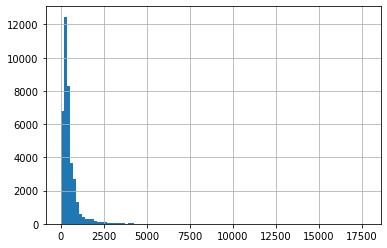

In [309]:
y_train.hist(bins=100)

In [310]:
from sklearn.linear_model import LinearRegression

In [311]:
model = LinearRegression(n_jobs=6)

In [312]:
%%time
model.fit(x_train, y_train)

LinAlgError: SVD did not converge in Linear Least Squares